# Setup

In [4]:
import logging
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedKFold
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# save notebook checkpoints
%autosave 60

# Printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Load data from the specified path
df = pd.read_feather("../Data/Data145.feather")

Autosaving every 60 seconds


In [5]:
# Select features and target variable from the dataset
features = df[['text', 'base_url']]
target = df['sentiment']

# Split the dataset into training and testing subsets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42)

# Append custom stop words to the English stop words list
custom_stop_words = stopwords.words('english')
custom_stop_words.extend(['rt', 'ep'])

# TF-IDF Approach

In [6]:
# Initialize TF-IDF vectorizer for the 'text' column with custom stop words
tfidf_vectorizer_text = TfidfVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_tfidf_text = tfidf_vectorizer_text.fit_transform(features_train['text'])
features_test_tfidf_text = tfidf_vectorizer_text.transform(features_test['text'])

# Initialize TF-IDF vectorizer for the 'base_url' column
tfidf_vectorizer_url = TfidfVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_tfidf_url = tfidf_vectorizer_url.fit_transform(features_train['base_url'])
features_test_tfidf_url = tfidf_vectorizer_url.transform(features_test['base_url'])

# Combine all TF-IDF feature matrices horizontally
features_train_tfidf_combined = hstack([features_train_tfidf_text, features_train_tfidf_url])
features_test_tfidf_combined = hstack([features_test_tfidf_text, features_test_tfidf_url])

## Vanilla Random Forest Classifier

In [7]:
# Define and train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(random_state=50, oob_score=True)
random_forest_classifier.fit(features_train_tfidf_combined, target_train)

RandomForestClassifier(oob_score=True, random_state=50)

Accuracy: 0.9248438893844781

OOB Score: 0.9227680811911002

Classification Report: 
               precision    recall  f1-score   support

          -1       0.90      0.71      0.80       491
           0       0.93      0.97      0.95      2587
           1       0.92      0.91      0.91      1406

    accuracy                           0.92      4484
   macro avg       0.92      0.87      0.89      4484
weighted avg       0.92      0.92      0.92      4484


Confusion Matrix:
      -1     0     1
-1  351    79    61
0    19  2511    57
1    19   102  1285


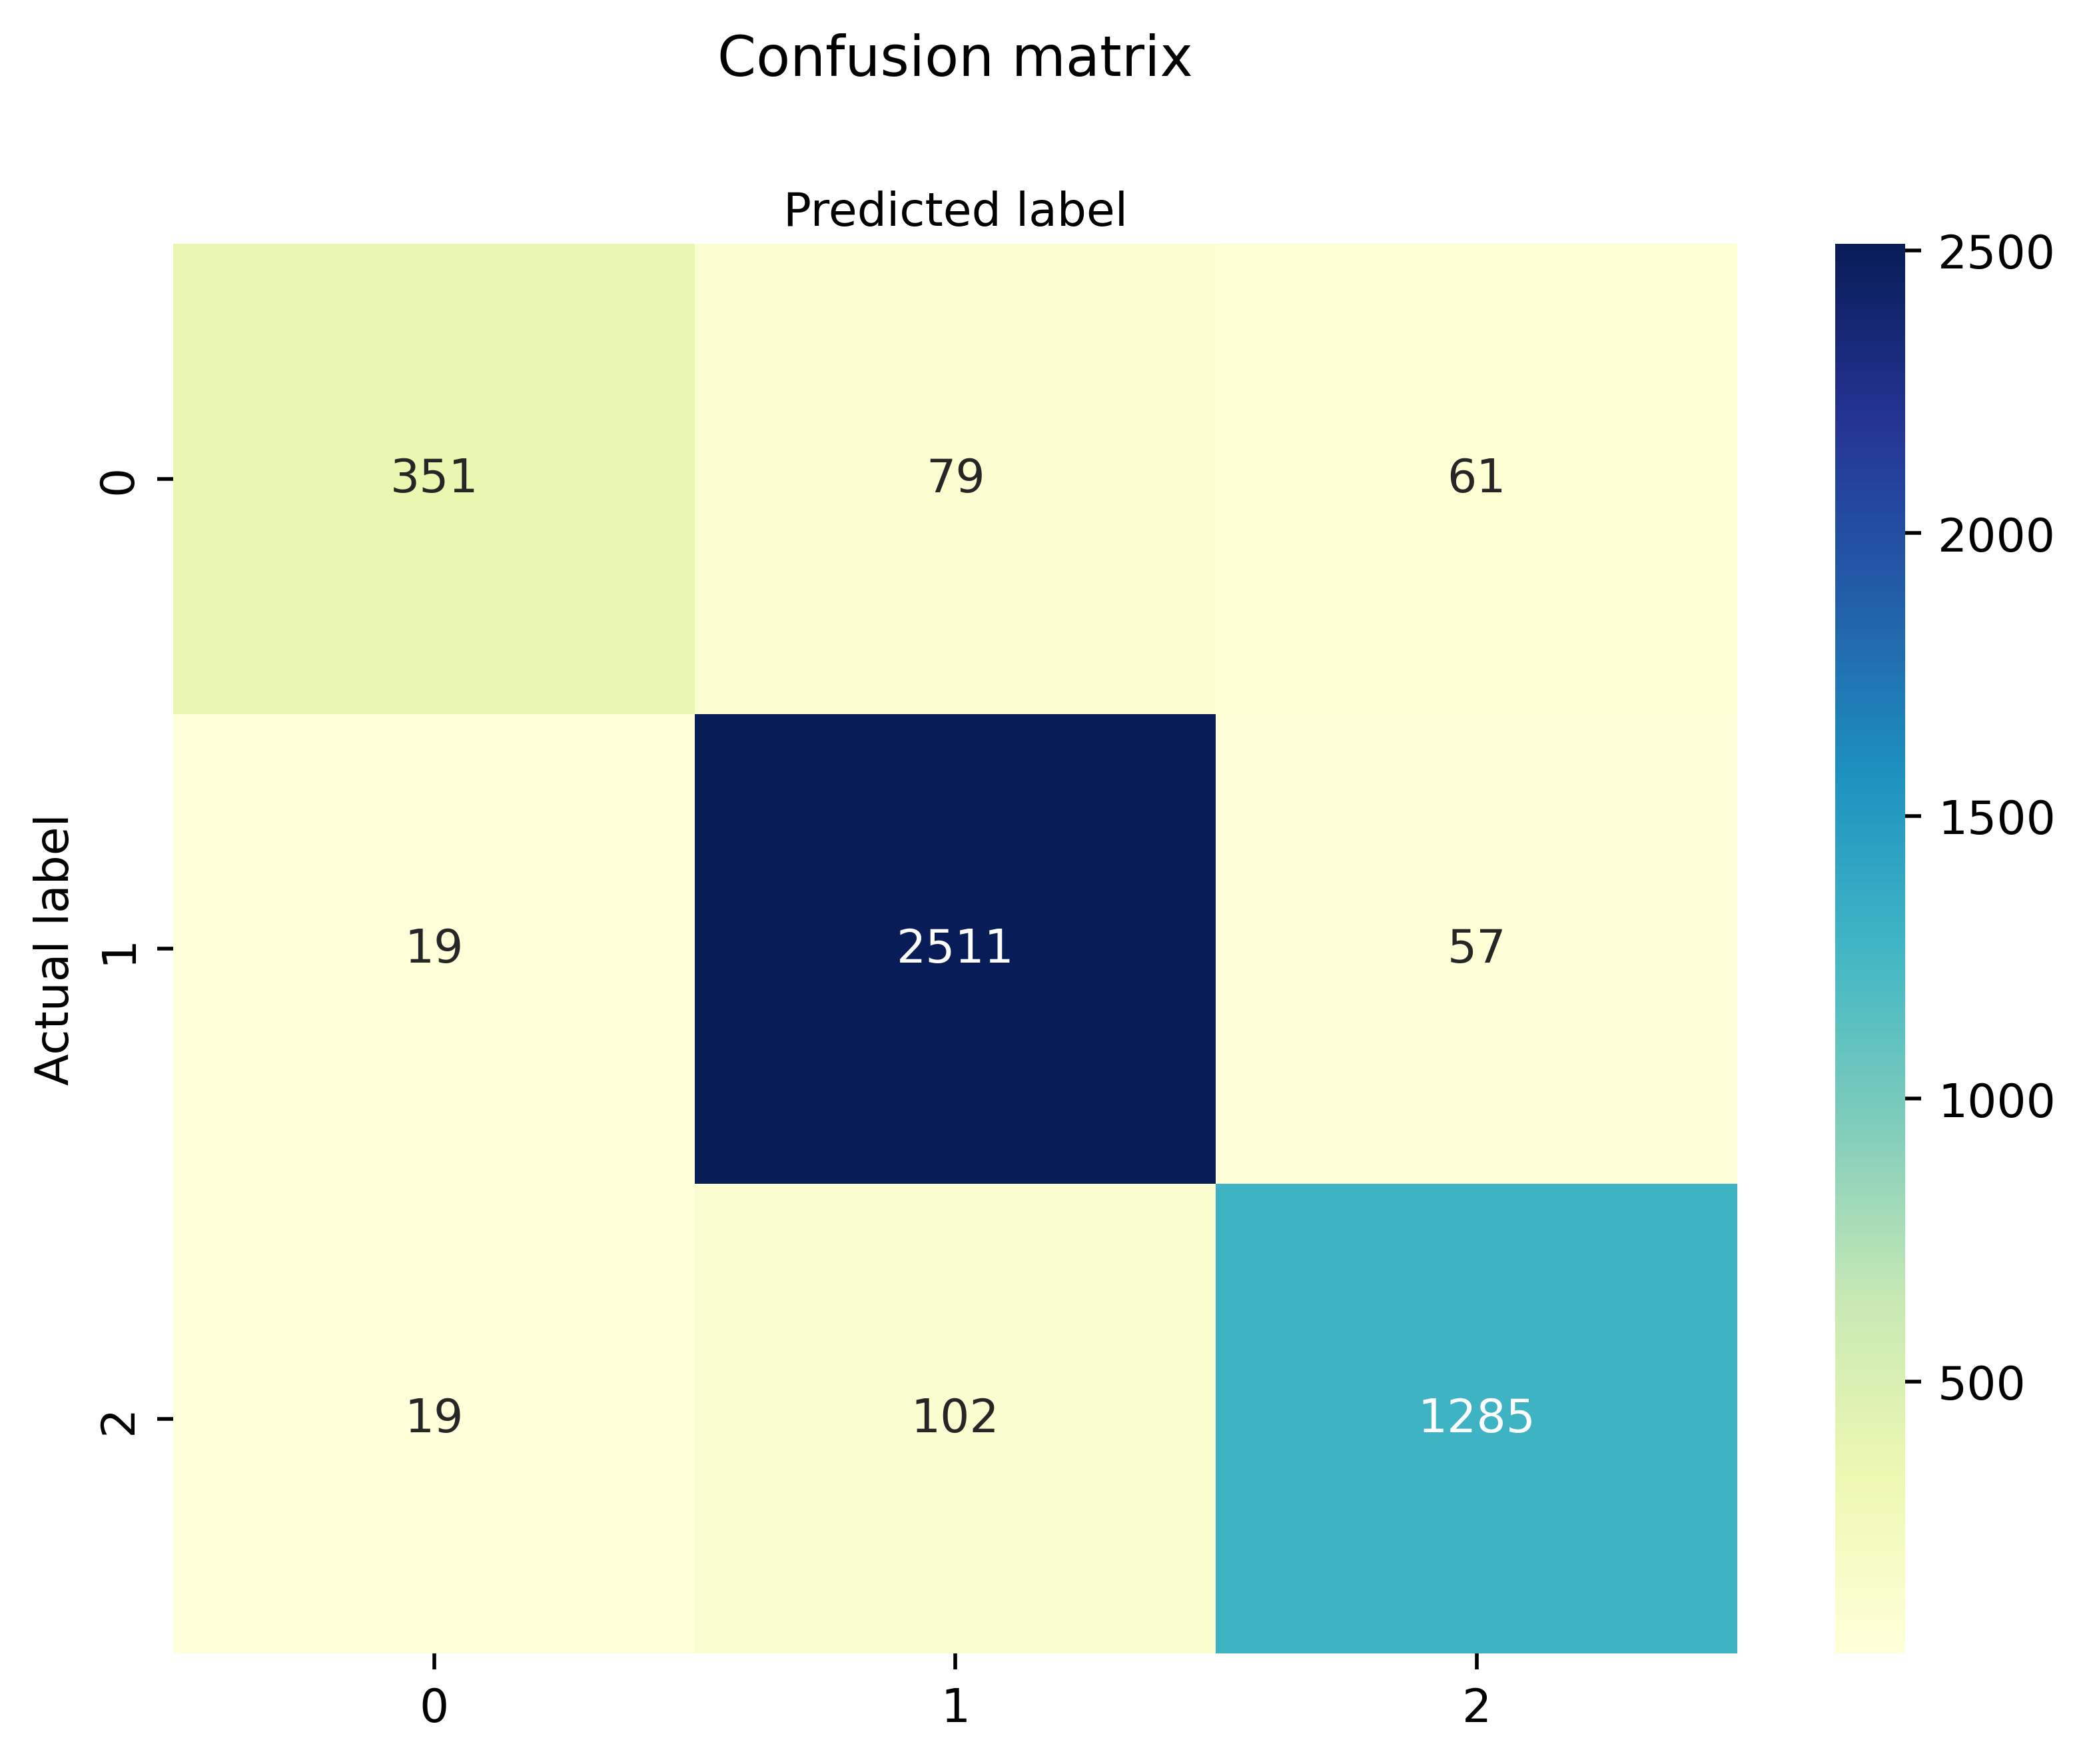

In [33]:
# Predict the sentiment on the test set and print accuracy
predictions = random_forest_classifier.predict(features_test_tfidf_combined)
accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy}")

# Calculate OOB Score
oob_score = random_forest_classifier.oob_score_
print(f"\nOOB Score: {oob_score}")

# Detailed classification report
print("\nClassification Report: \n", classification_report(target_test, predictions))

# Print and Plot Confusion Matrix
cm = confusion_matrix(target_test, predictions)
df_cm = pd.DataFrame(cm, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("\nConfusion Matrix:\n", df_cm)
plot_conf_mat(cm)

## Random Forest Classifier with Feature Bagging

In [55]:
classifier_with_bagging = RandomForestClassifier(max_features='sqrt', oob_score=True)
classifier_with_bagging.fit(features_train_tfidf_combined, target_train)

RandomForestClassifier(oob_score=True)

Accuracy: 0.9261819803746655

OOB Score: 0.9223777393631852

Classification Report: 
               precision    recall  f1-score   support

          -1       0.90      0.72      0.80       491
           0       0.93      0.97      0.95      2587
           1       0.92      0.91      0.92      1406

    accuracy                           0.93      4484
   macro avg       0.92      0.87      0.89      4484
weighted avg       0.93      0.93      0.92      4484

Confusion Matrix:
      -1     0     1
-1  353    77    61
0    16  2516    55
1    24    98  1284


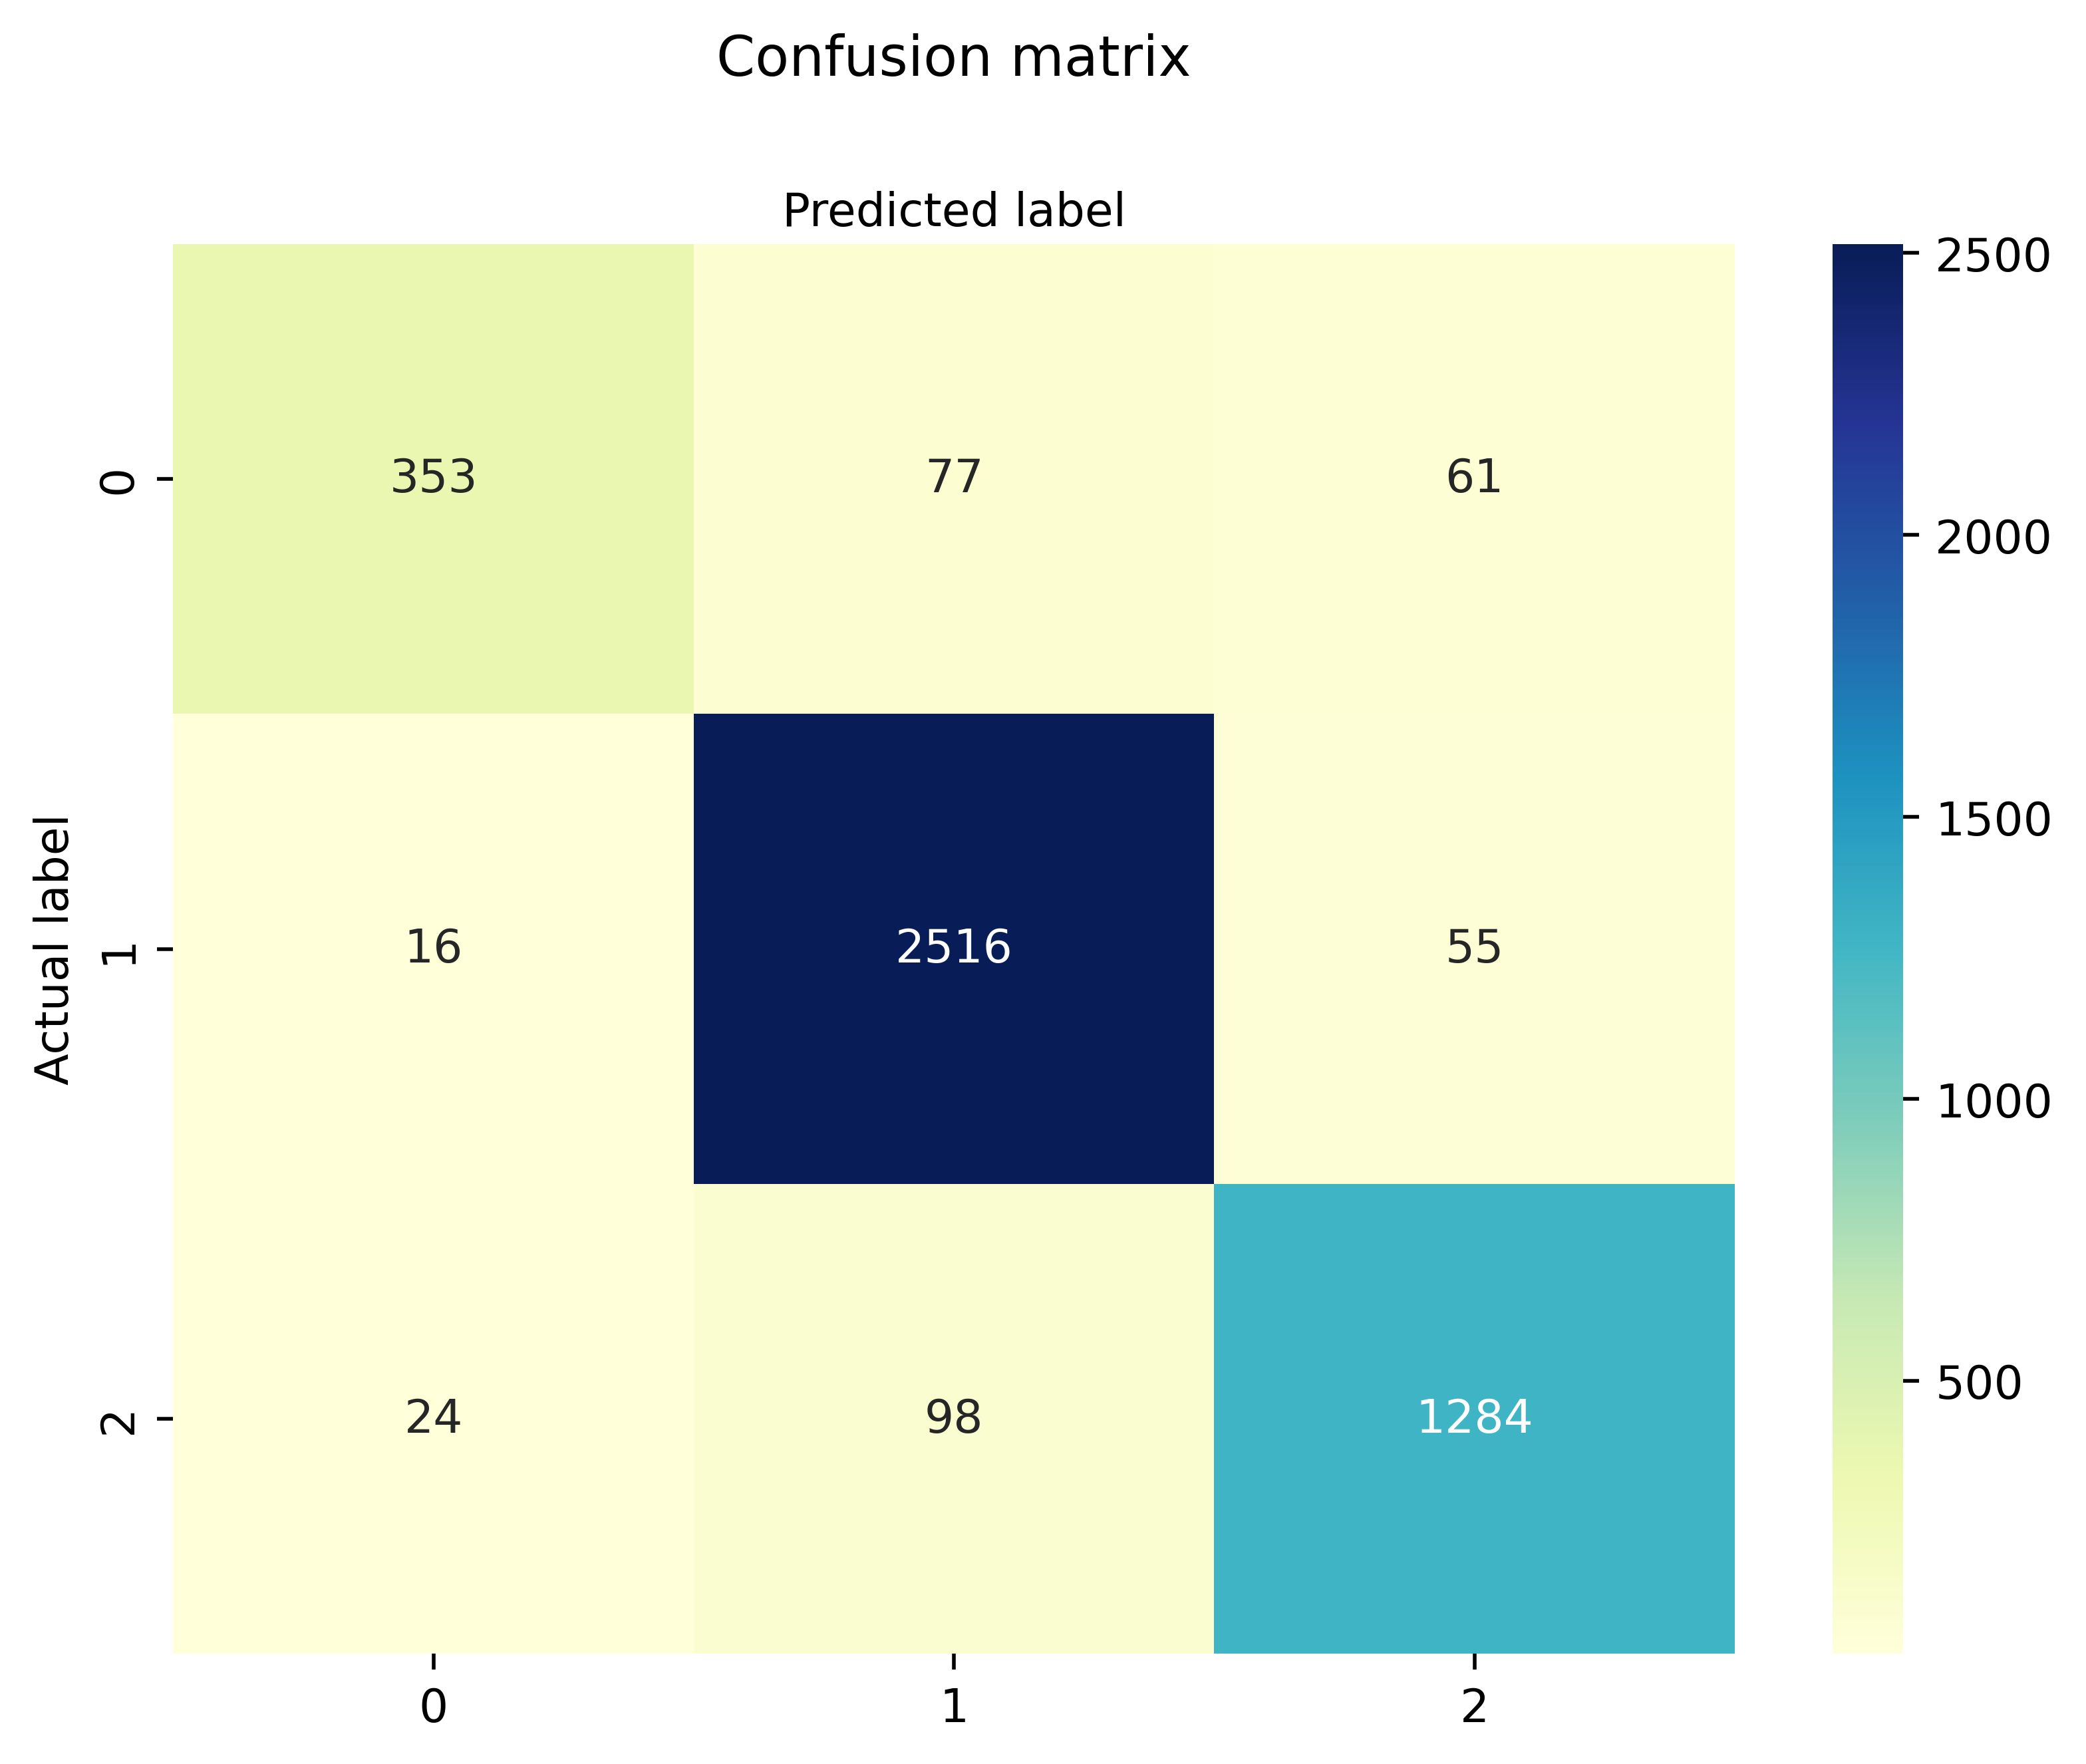

In [56]:
# Predict and evaluate the model
predictions_bagging = classifier_with_bagging.predict(features_test_tfidf_combined)
accuracy_bagging = accuracy_score(target_test, predictions_bagging)
print(f"Accuracy: {accuracy_bagging}")

# Calculate OOB Score
oob_score_bagging = classifier_with_bagging.oob_score_
print(f"\nOOB Score: {oob_score_bagging}")

# Detailed classification report for Bagging Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_bagging))

# Print and Plot Confusion Matrix for Bagging Classifier
cm_bagging = confusion_matrix(target_test, predictions_bagging)
df_cm_bagging = pd.DataFrame(cm_bagging, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_bagging)
plot_conf_mat(cm_bagging)

## Gradient Boosting Classifier

In [9]:
# Gradient Boosting Classifier configuration and training
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_depth=10)
gradient_boosting_classifier.fit(features_train_tfidf_combined, target_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=10, n_estimators=50)

Accuracy: 0.91971454058876

OOB Score: 0.9674343389282328

Classification Report: 
               precision    recall  f1-score   support

          -1       0.85      0.70      0.77       491
           0       0.92      0.98      0.95      2587
           1       0.94      0.89      0.91      1406

    accuracy                           0.92      4484
   macro avg       0.90      0.86      0.88      4484
weighted avg       0.92      0.92      0.92      4484

Confusion Matrix:
      -1     0     1
-1  345    96    50
0    28  2524    35
1    31   120  1255


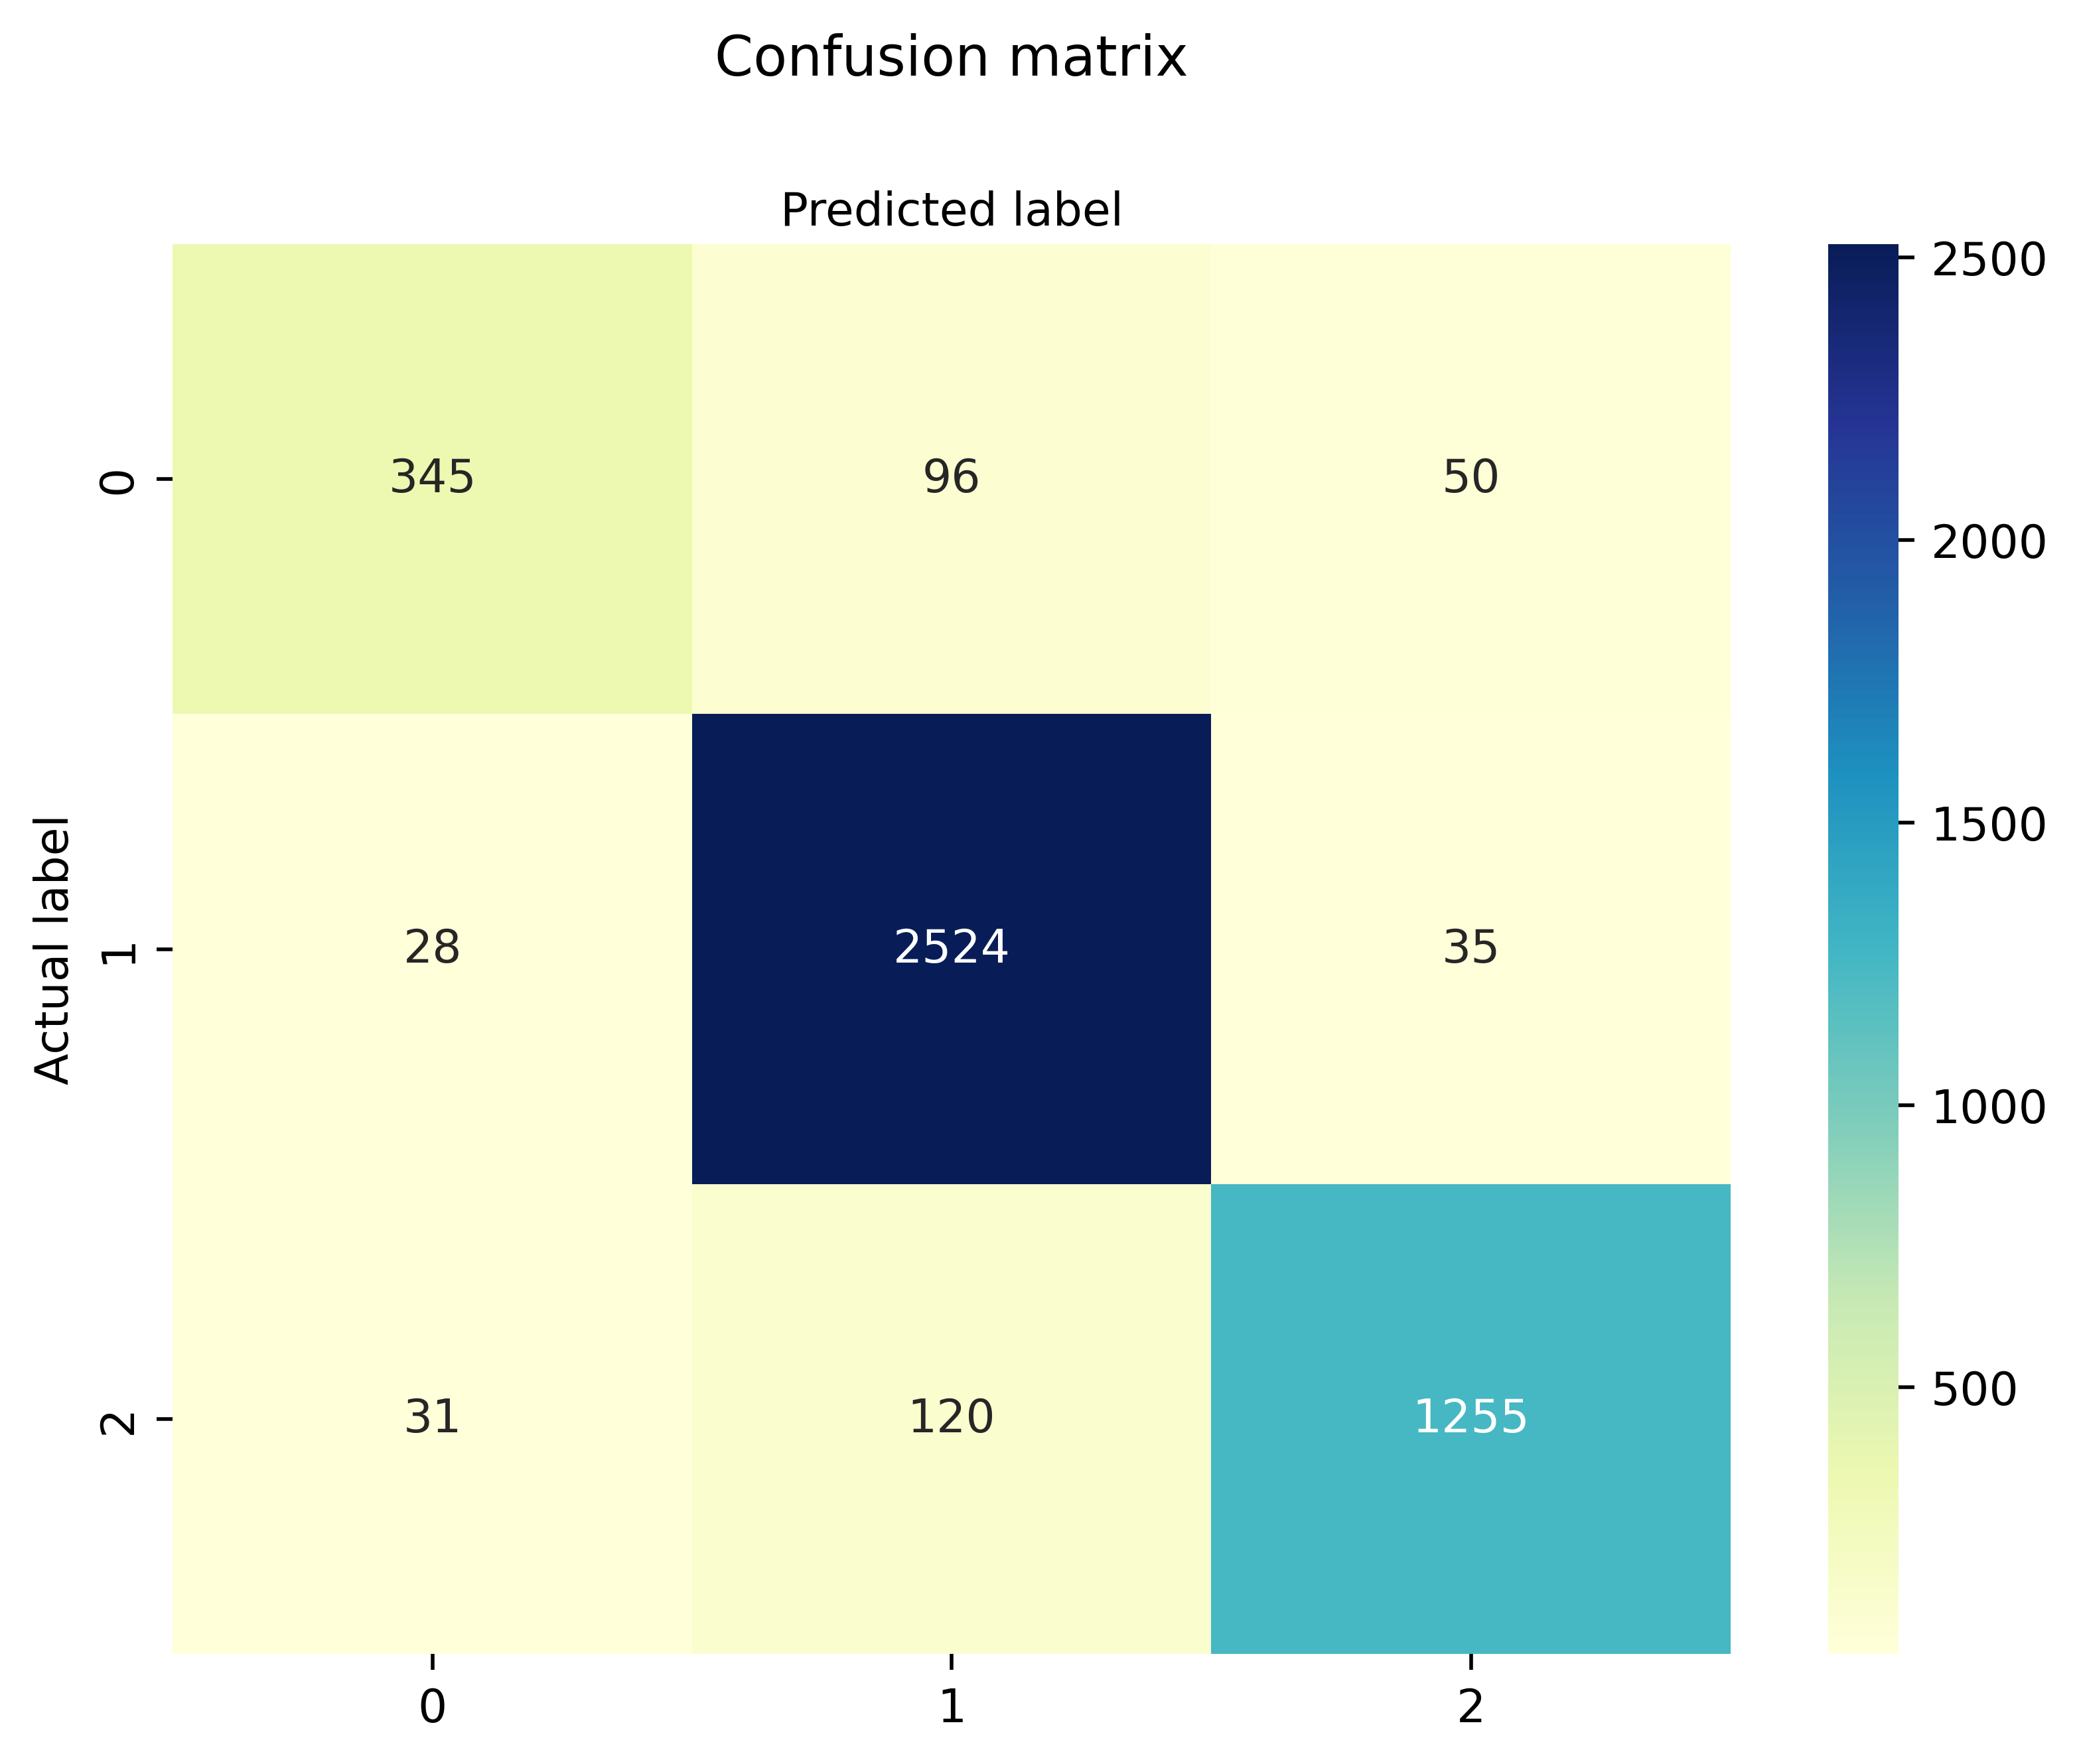

In [36]:
# Predict and evaluate the model
predictions_gb = gradient_boosting_classifier.predict(features_test_tfidf_combined)
accuracy_gb = accuracy_score(target_test, predictions_gb)
print(f"Accuracy: {accuracy_gb}")

# Calculate OOB Score
oob_score_gb = gradient_boosting_classifier.score(features_train_tfidf_combined, target_train)
print(f"\nOOB Score: {oob_score_gb}")

# Detailed classification report for Gradient Boosting Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_gb))

# Print and Plot Confusion Matrix for Gradient Boosting Classifier
cm_gb = confusion_matrix(target_test, predictions_gb)
df_cm_gb = pd.DataFrame(cm_gb, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_gb)
plot_conf_mat(cm_gb)

## Voting Classifier

In [11]:
# Define individual Random Forest classifiers for a voting ensemble
rf_classifier1 = RandomForestClassifier(n_estimators=100)
rf_classifier2 = RandomForestClassifier(n_estimators=70)
rf_classifier3 = RandomForestClassifier(n_estimators=80)

# Create and train a Voting Classifier with the defined Random Forest models
voting_classifier = VotingClassifier(estimators=[
    ('rf1', rf_classifier1),
    ('rf2', rf_classifier2),
    ('rf3', rf_classifier3)
])
voting_classifier.fit(features_train_tfidf_combined, target_train)

VotingClassifier(estimators=[('rf1', RandomForestClassifier()),
                             ('rf2', RandomForestClassifier(n_estimators=70)),
                             ('rf3', RandomForestClassifier(n_estimators=80))])

Accuracy: 0.9246208742194469

OOB Score: 0.9976021859142363

Classification Report: 
               precision    recall  f1-score   support

          -1       0.91      0.71      0.80       491
           0       0.93      0.97      0.95      2587
           1       0.91      0.91      0.91      1406

    accuracy                           0.92      4484
   macro avg       0.92      0.87      0.89      4484
weighted avg       0.92      0.92      0.92      4484

Confusion Matrix:
      -1     0     1
-1  350    81    60
0    15  2510    62
1    21    99  1286


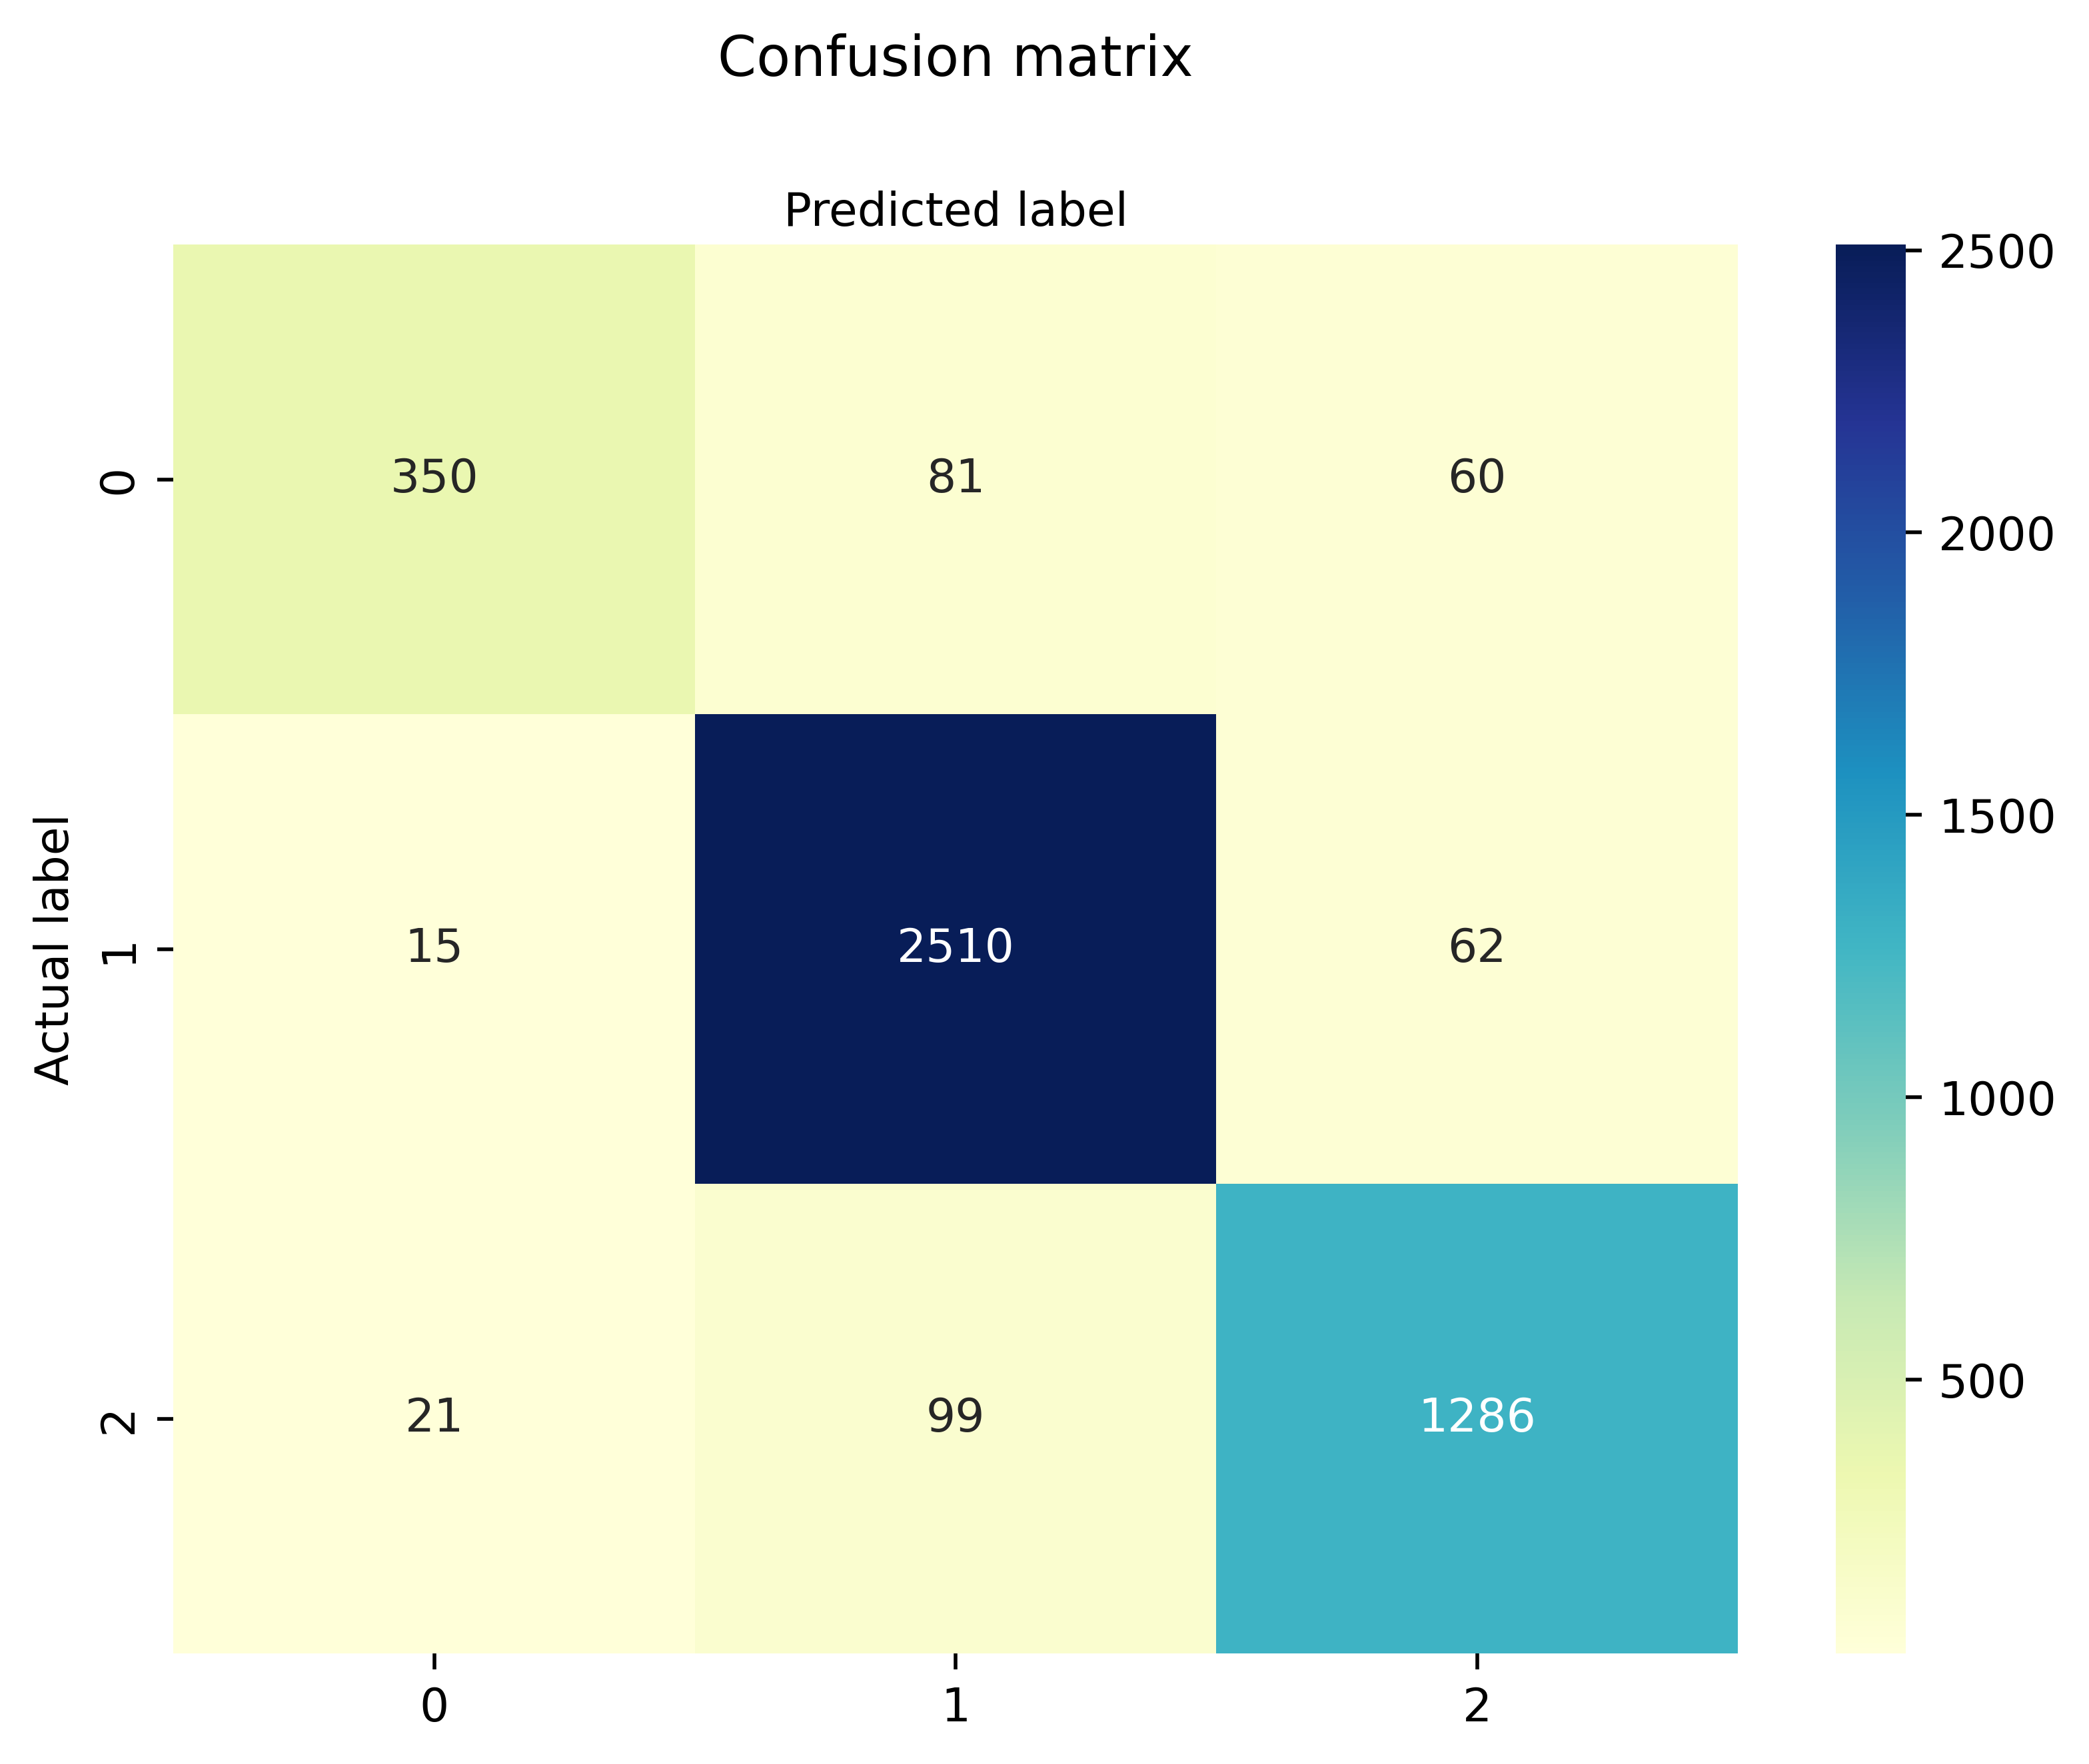

In [37]:
# Make predictions with the Voting Classifier and evaluate
predictions_voting = voting_classifier.predict(features_test_tfidf_combined)
accuracy_voting = accuracy_score(target_test, predictions_voting)
print(f"Accuracy: {accuracy_voting}")

# Calculate OOB Score
oob_score_voting = voting_classifier.score(features_train_tfidf_combined, target_train)
print(f"\nOOB Score: {oob_score_voting}")

# Detailed classification report for Voting Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_voting))

# Print and Plot Confusion Matrix for Voting Classifier
cm_voting = confusion_matrix(target_test, predictions_voting)
df_cm_voting = pd.DataFrame(cm_voting, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_voting)
plot_conf_mat(cm_voting)

# BoW Approach

In [7]:
# Initialize TF-IDF vectorizer for the 'text' column with custom stop words
bow_vectorizer_text = CountVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_bow_text = bow_vectorizer_text.fit_transform(features_train['text'])
features_test_bow_text = bow_vectorizer_text.transform(features_test['text'])

# Initialize TF-IDF vectorizer for the 'base_url' column
bow_vectorizer_url = CountVectorizer(stop_words=custom_stop_words, max_features=1000)
features_train_bow_url = bow_vectorizer_url.fit_transform(features_train['base_url'])
features_test_bow_url = bow_vectorizer_url.transform(features_test['base_url'])

# Combine all TF-IDF feature matrices horizontally
features_train_bow_combined = hstack([features_train_bow_text, features_train_bow_url])
features_test_bow_combined = hstack([features_test_bow_text, features_test_bow_url])

## Vanilla Random Forest Classifier

In [58]:
# Define and train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(random_state=50, oob_score=True)
random_forest_classifier.fit(features_train_bow_combined, target_train)

RandomForestClassifier(oob_score=True, random_state=50)

Accuracy: 0.9235057983942908

OOB Score: 0.923325712373836

Classification Report: 
               precision    recall  f1-score   support

          -1       0.88      0.73      0.80       491
           0       0.94      0.96      0.95      2587
           1       0.91      0.92      0.91      1406

    accuracy                           0.92      4484
   macro avg       0.91      0.87      0.89      4484
weighted avg       0.92      0.92      0.92      4484


Confusion Matrix:
      -1     0     1
-1  360    74    57
0    22  2491    74
1    27    89  1290


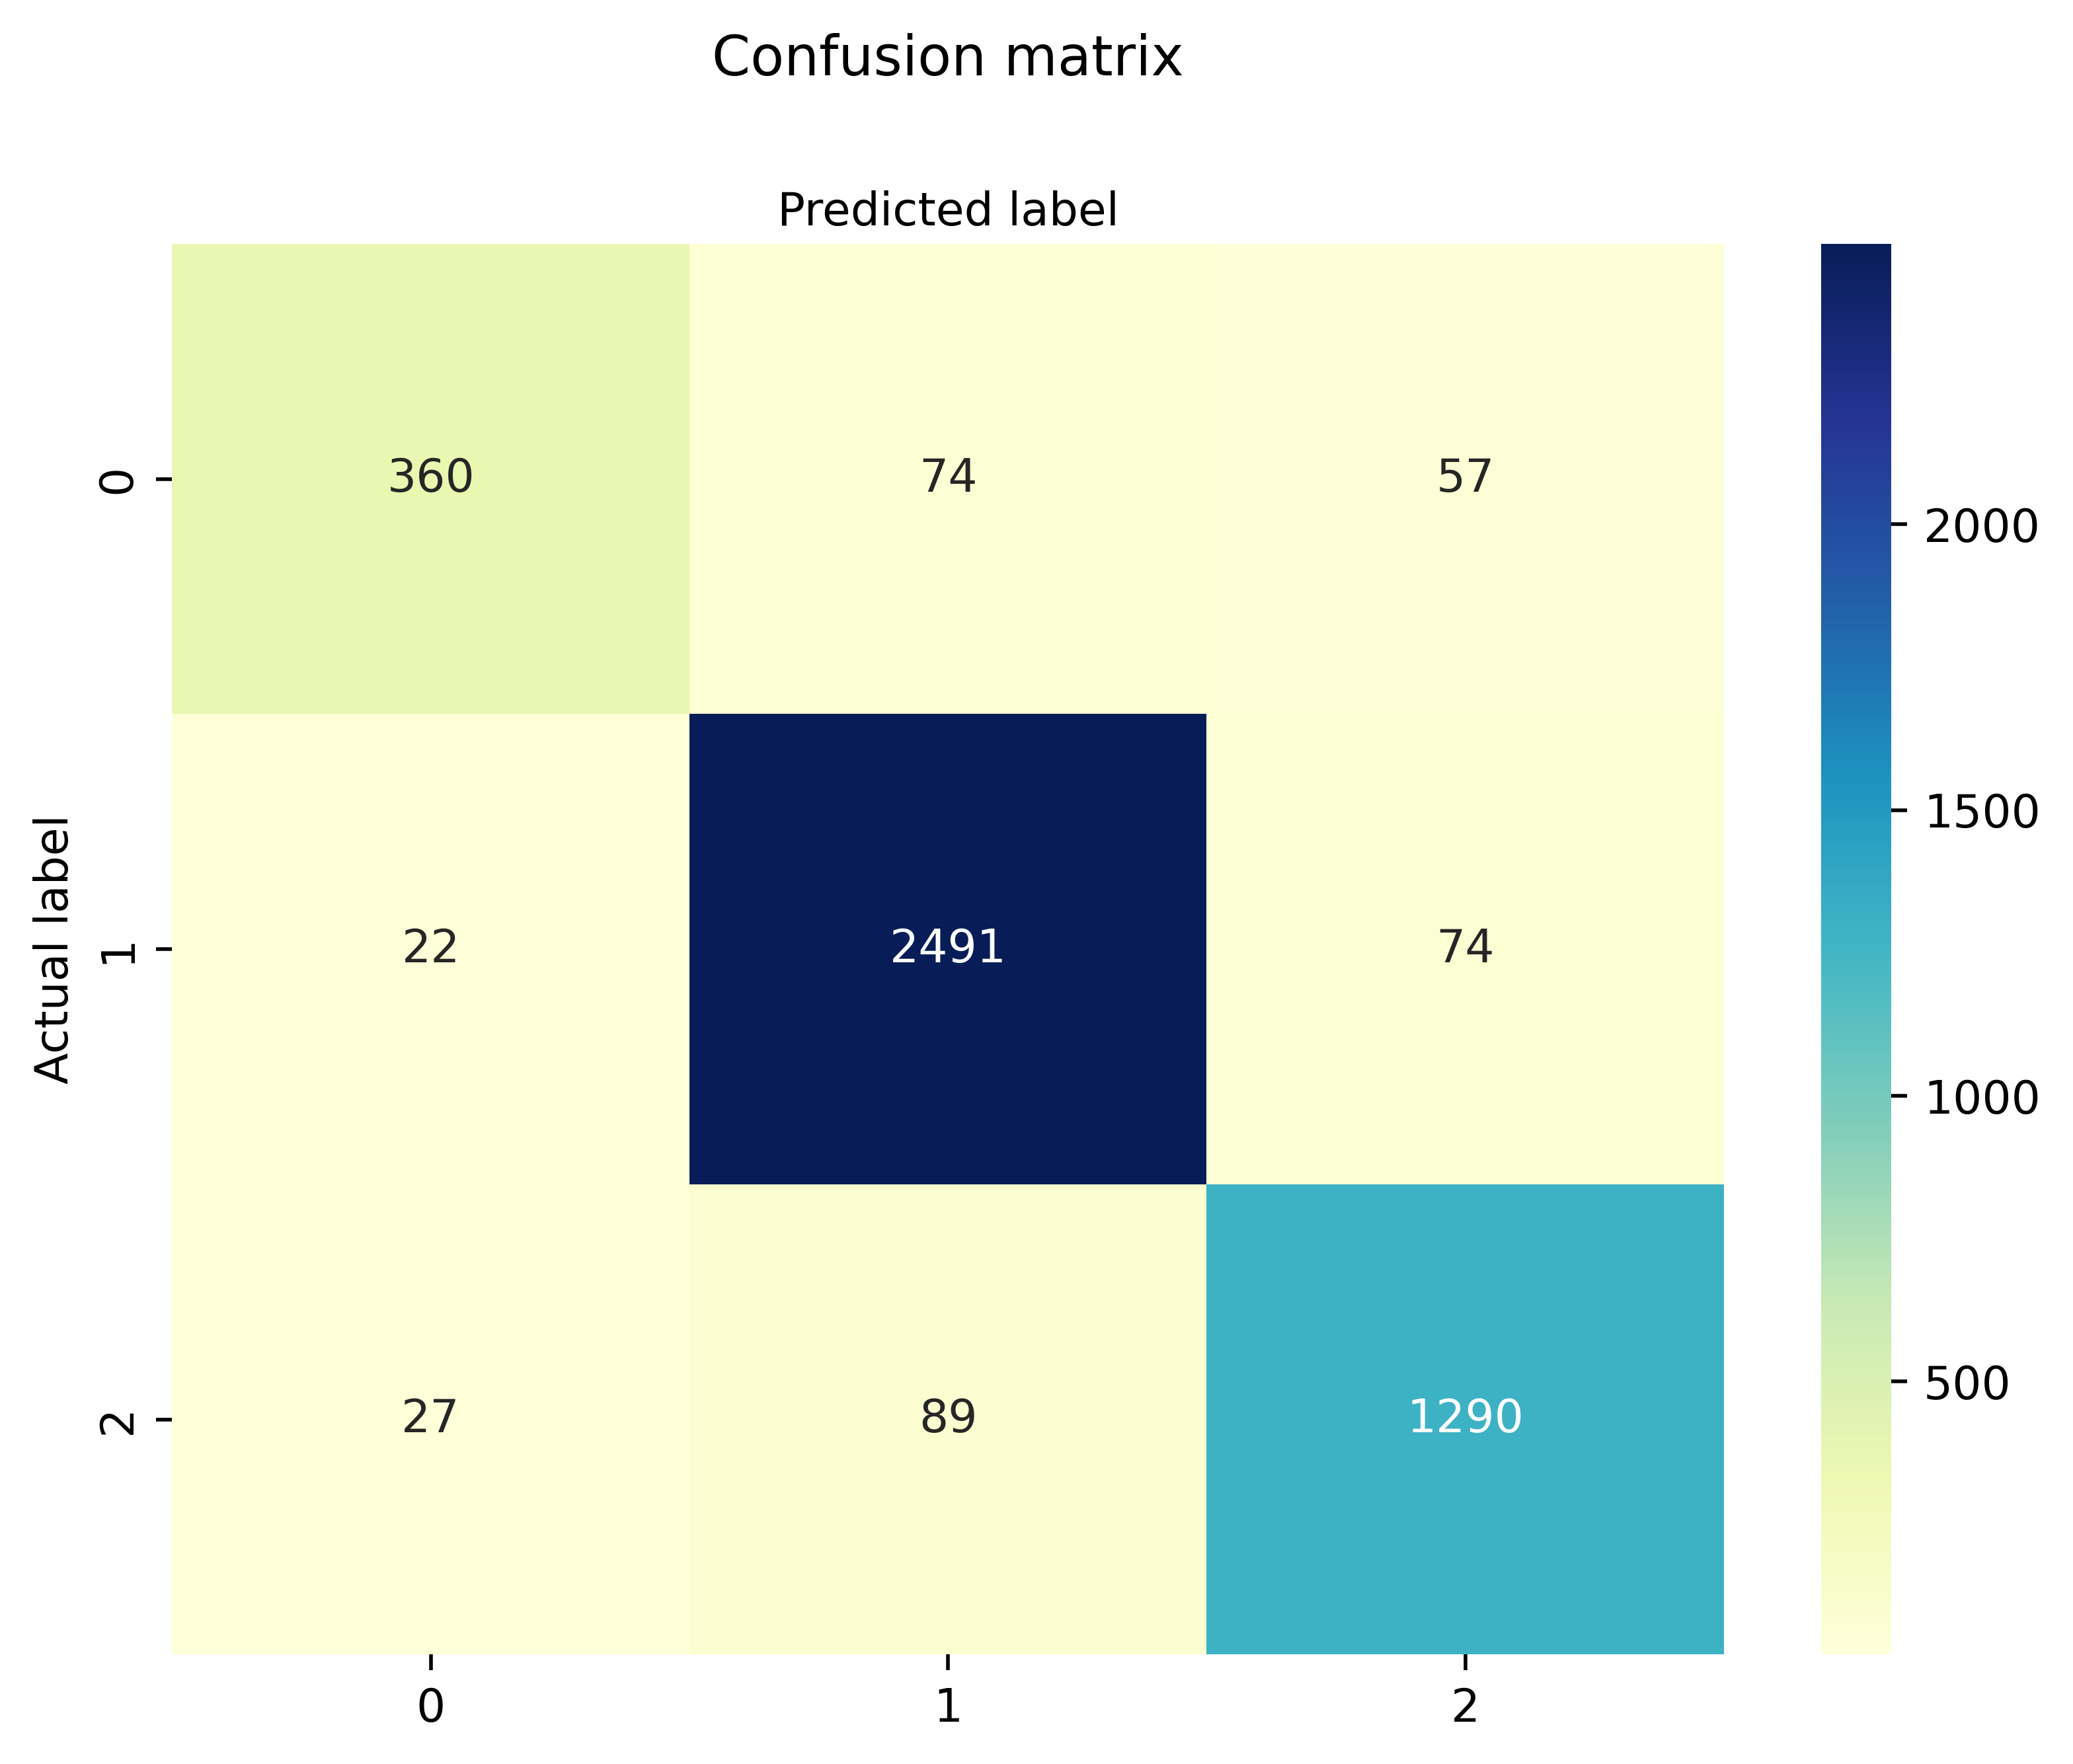

In [59]:
# Predict the sentiment on the test set and print accuracy
predictions = random_forest_classifier.predict(features_test_bow_combined)
accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy}")

# Calculate OOB Score
oob_score = random_forest_classifier.oob_score_
print(f"\nOOB Score: {oob_score}")

# Detailed classification report
print("\nClassification Report: \n", classification_report(target_test, predictions))

# Print and Plot Confusion Matrix
cm = confusion_matrix(target_test, predictions)
df_cm = pd.DataFrame(cm, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("\nConfusion Matrix:\n", df_cm)
plot_conf_mat(cm)

## Random Forest Classifier with Feature Bagging

In [60]:
classifier_with_bagging = RandomForestClassifier(max_features='sqrt', oob_score=True)
classifier_with_bagging.fit(features_train_bow_combined, target_train)

RandomForestClassifier(oob_score=True)

Accuracy: 0.923728813559322

OOB Score: 0.9228796074276474

Classification Report: 
               precision    recall  f1-score   support

          -1       0.89      0.74      0.81       491
           0       0.94      0.96      0.95      2587
           1       0.91      0.91      0.91      1406

    accuracy                           0.92      4484
   macro avg       0.91      0.87      0.89      4484
weighted avg       0.92      0.92      0.92      4484

Confusion Matrix:
      -1     0     1
-1  363    74    54
0    19  2496    72
1    27    96  1283


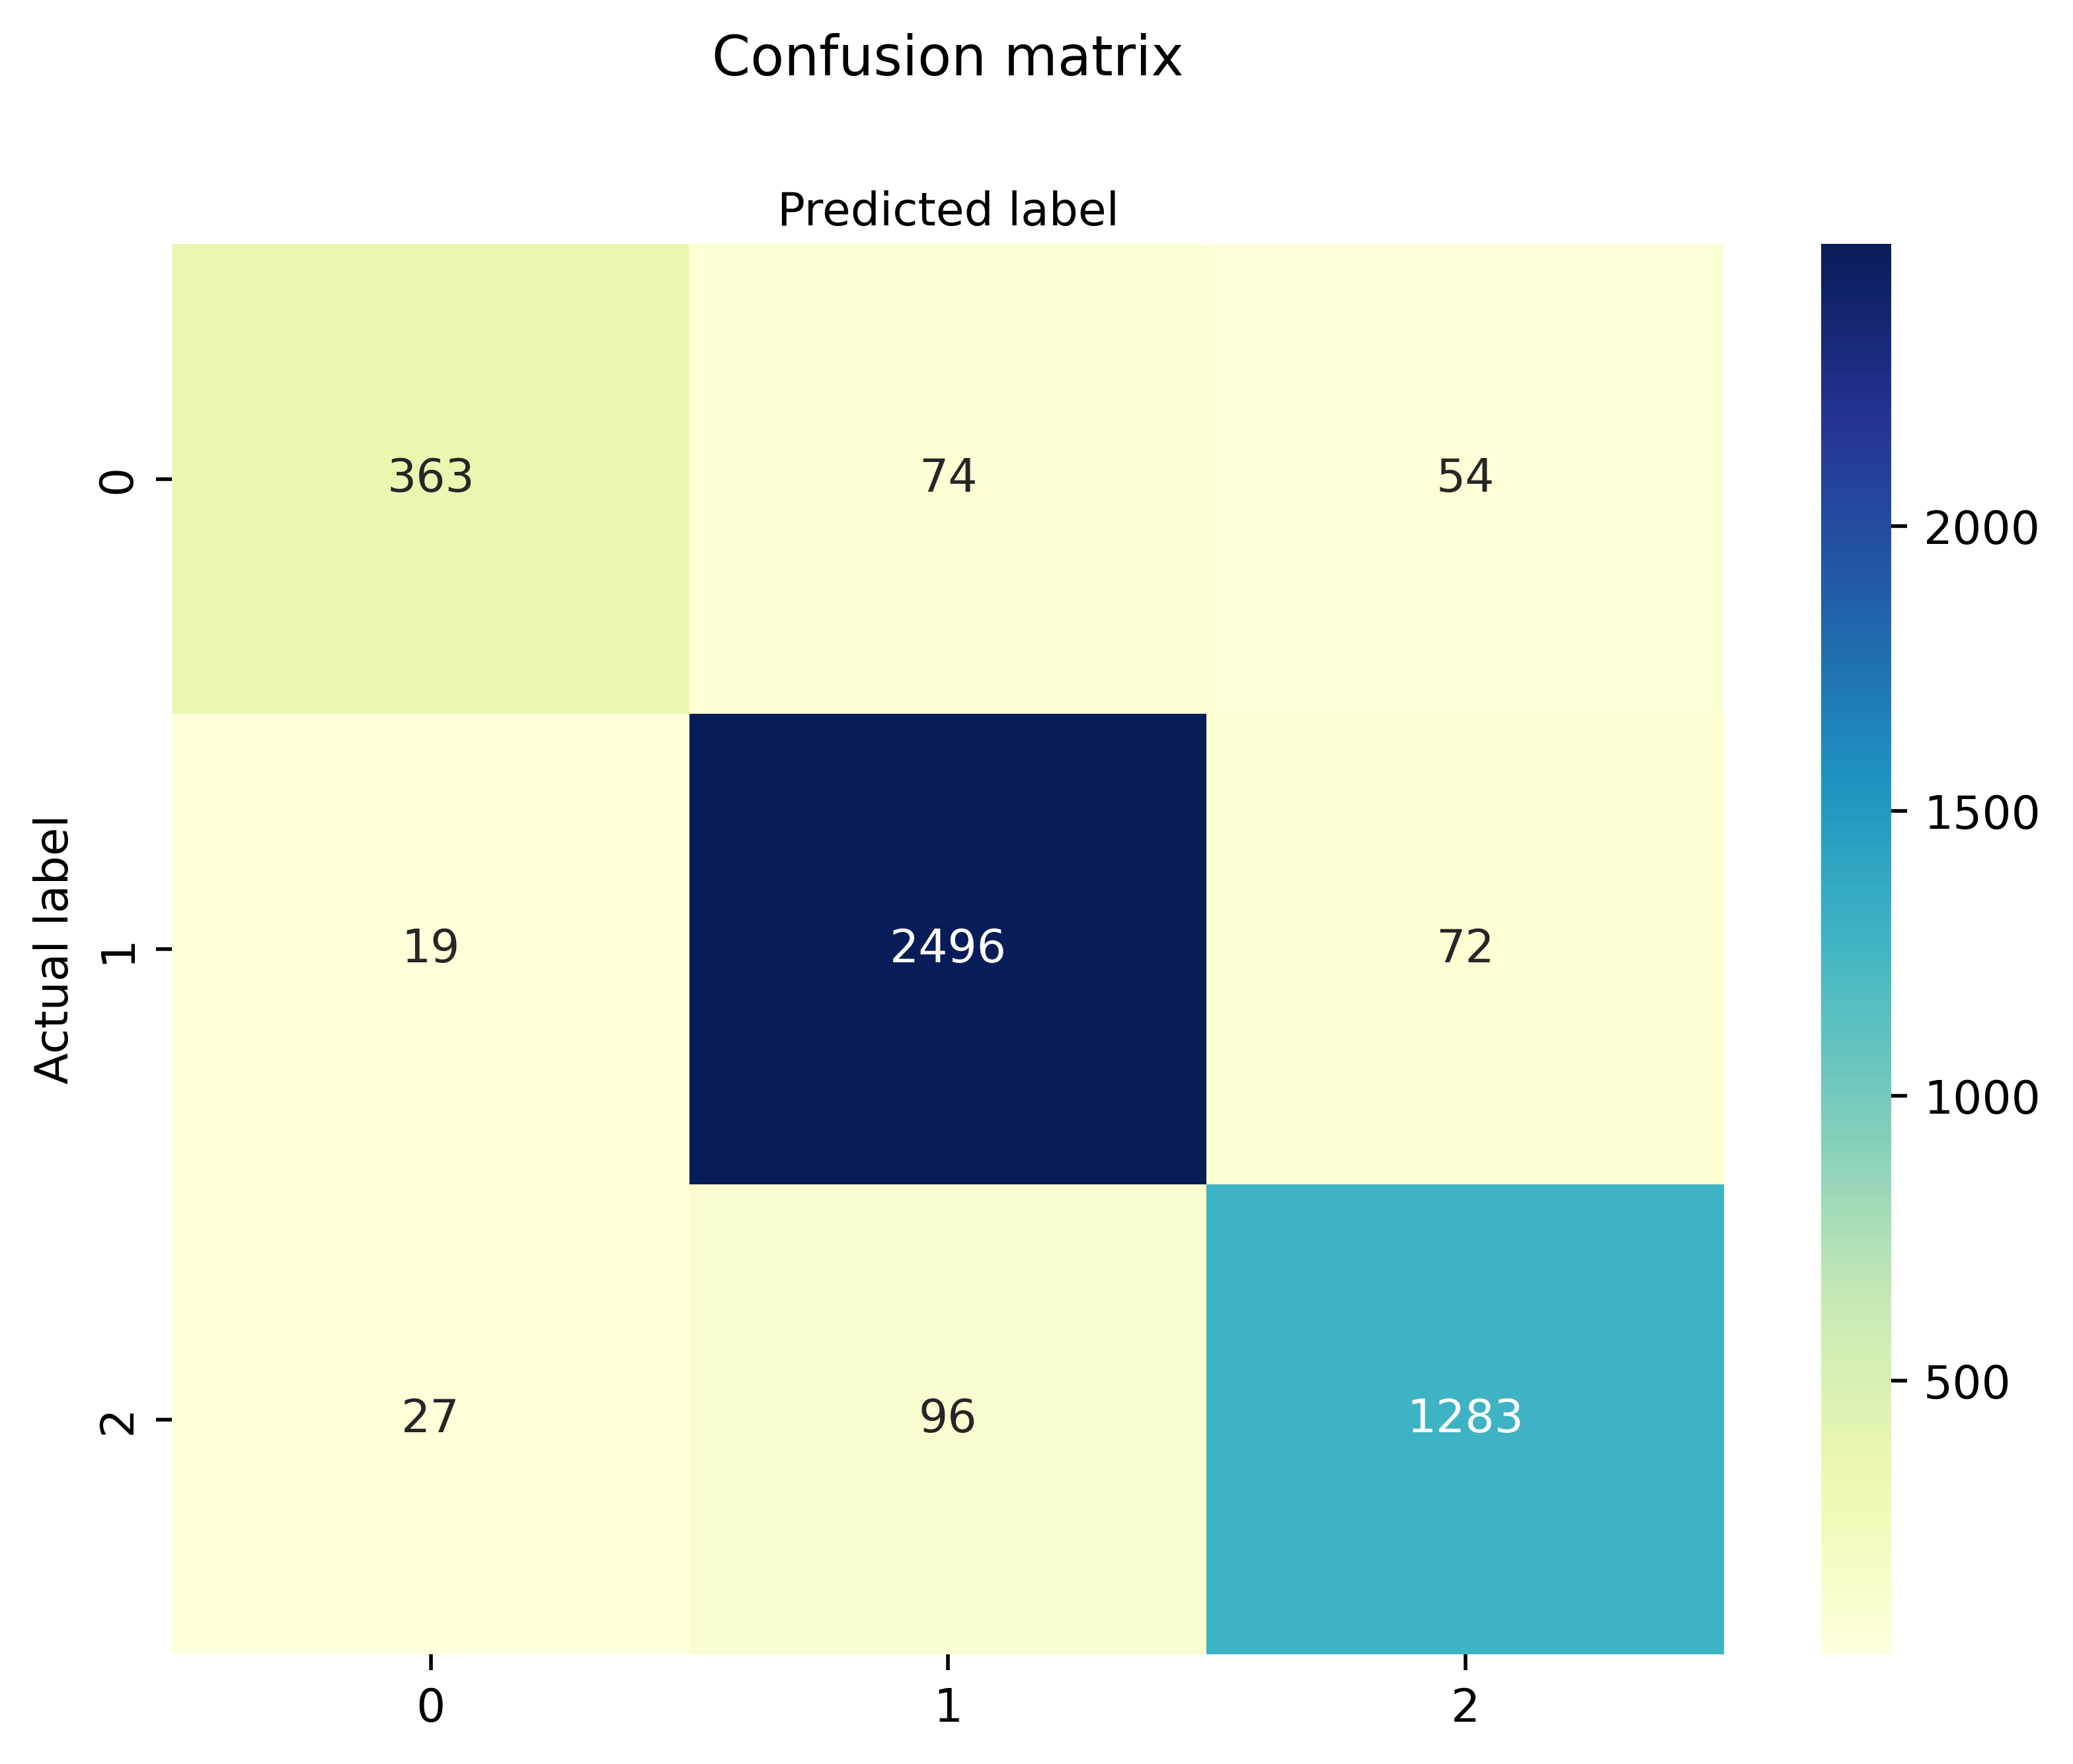

In [61]:
# Predict and evaluate the model
predictions_bagging = classifier_with_bagging.predict(features_test_bow_combined)
accuracy_bagging = accuracy_score(target_test, predictions_bagging)
print(f"Accuracy: {accuracy_bagging}")

# Calculate OOB Score
oob_score_bagging = classifier_with_bagging.oob_score_
print(f"\nOOB Score: {oob_score_bagging}")

# Detailed classification report for Bagging Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_bagging))

# Print and Plot Confusion Matrix for Bagging Classifier
cm_bagging = confusion_matrix(target_test, predictions_bagging)
df_cm_bagging = pd.DataFrame(cm_bagging, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_bagging)
plot_conf_mat(cm_bagging)

## Gradient Boosting Classifier

In [62]:
# Gradient Boosting Classifier configuration and training
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_depth=10)
gradient_boosting_classifier.fit(features_train_bow_combined, target_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=10, n_estimators=50)

Accuracy: 0.9248438893844781



OOB Score: 0.9623598951653376

Classification Report: 
               precision    recall  f1-score   support

          -1       0.86      0.72      0.79       491
           0       0.92      0.98      0.95      2587
           1       0.95      0.89      0.92      1406

    accuracy                           0.92      4484
   macro avg       0.91      0.86      0.88      4484
weighted avg       0.92      0.92      0.92      4484

Confusion Matrix:
      -1     0     1
-1  355    91    45
0    19  2543    25
1    39   118  1249


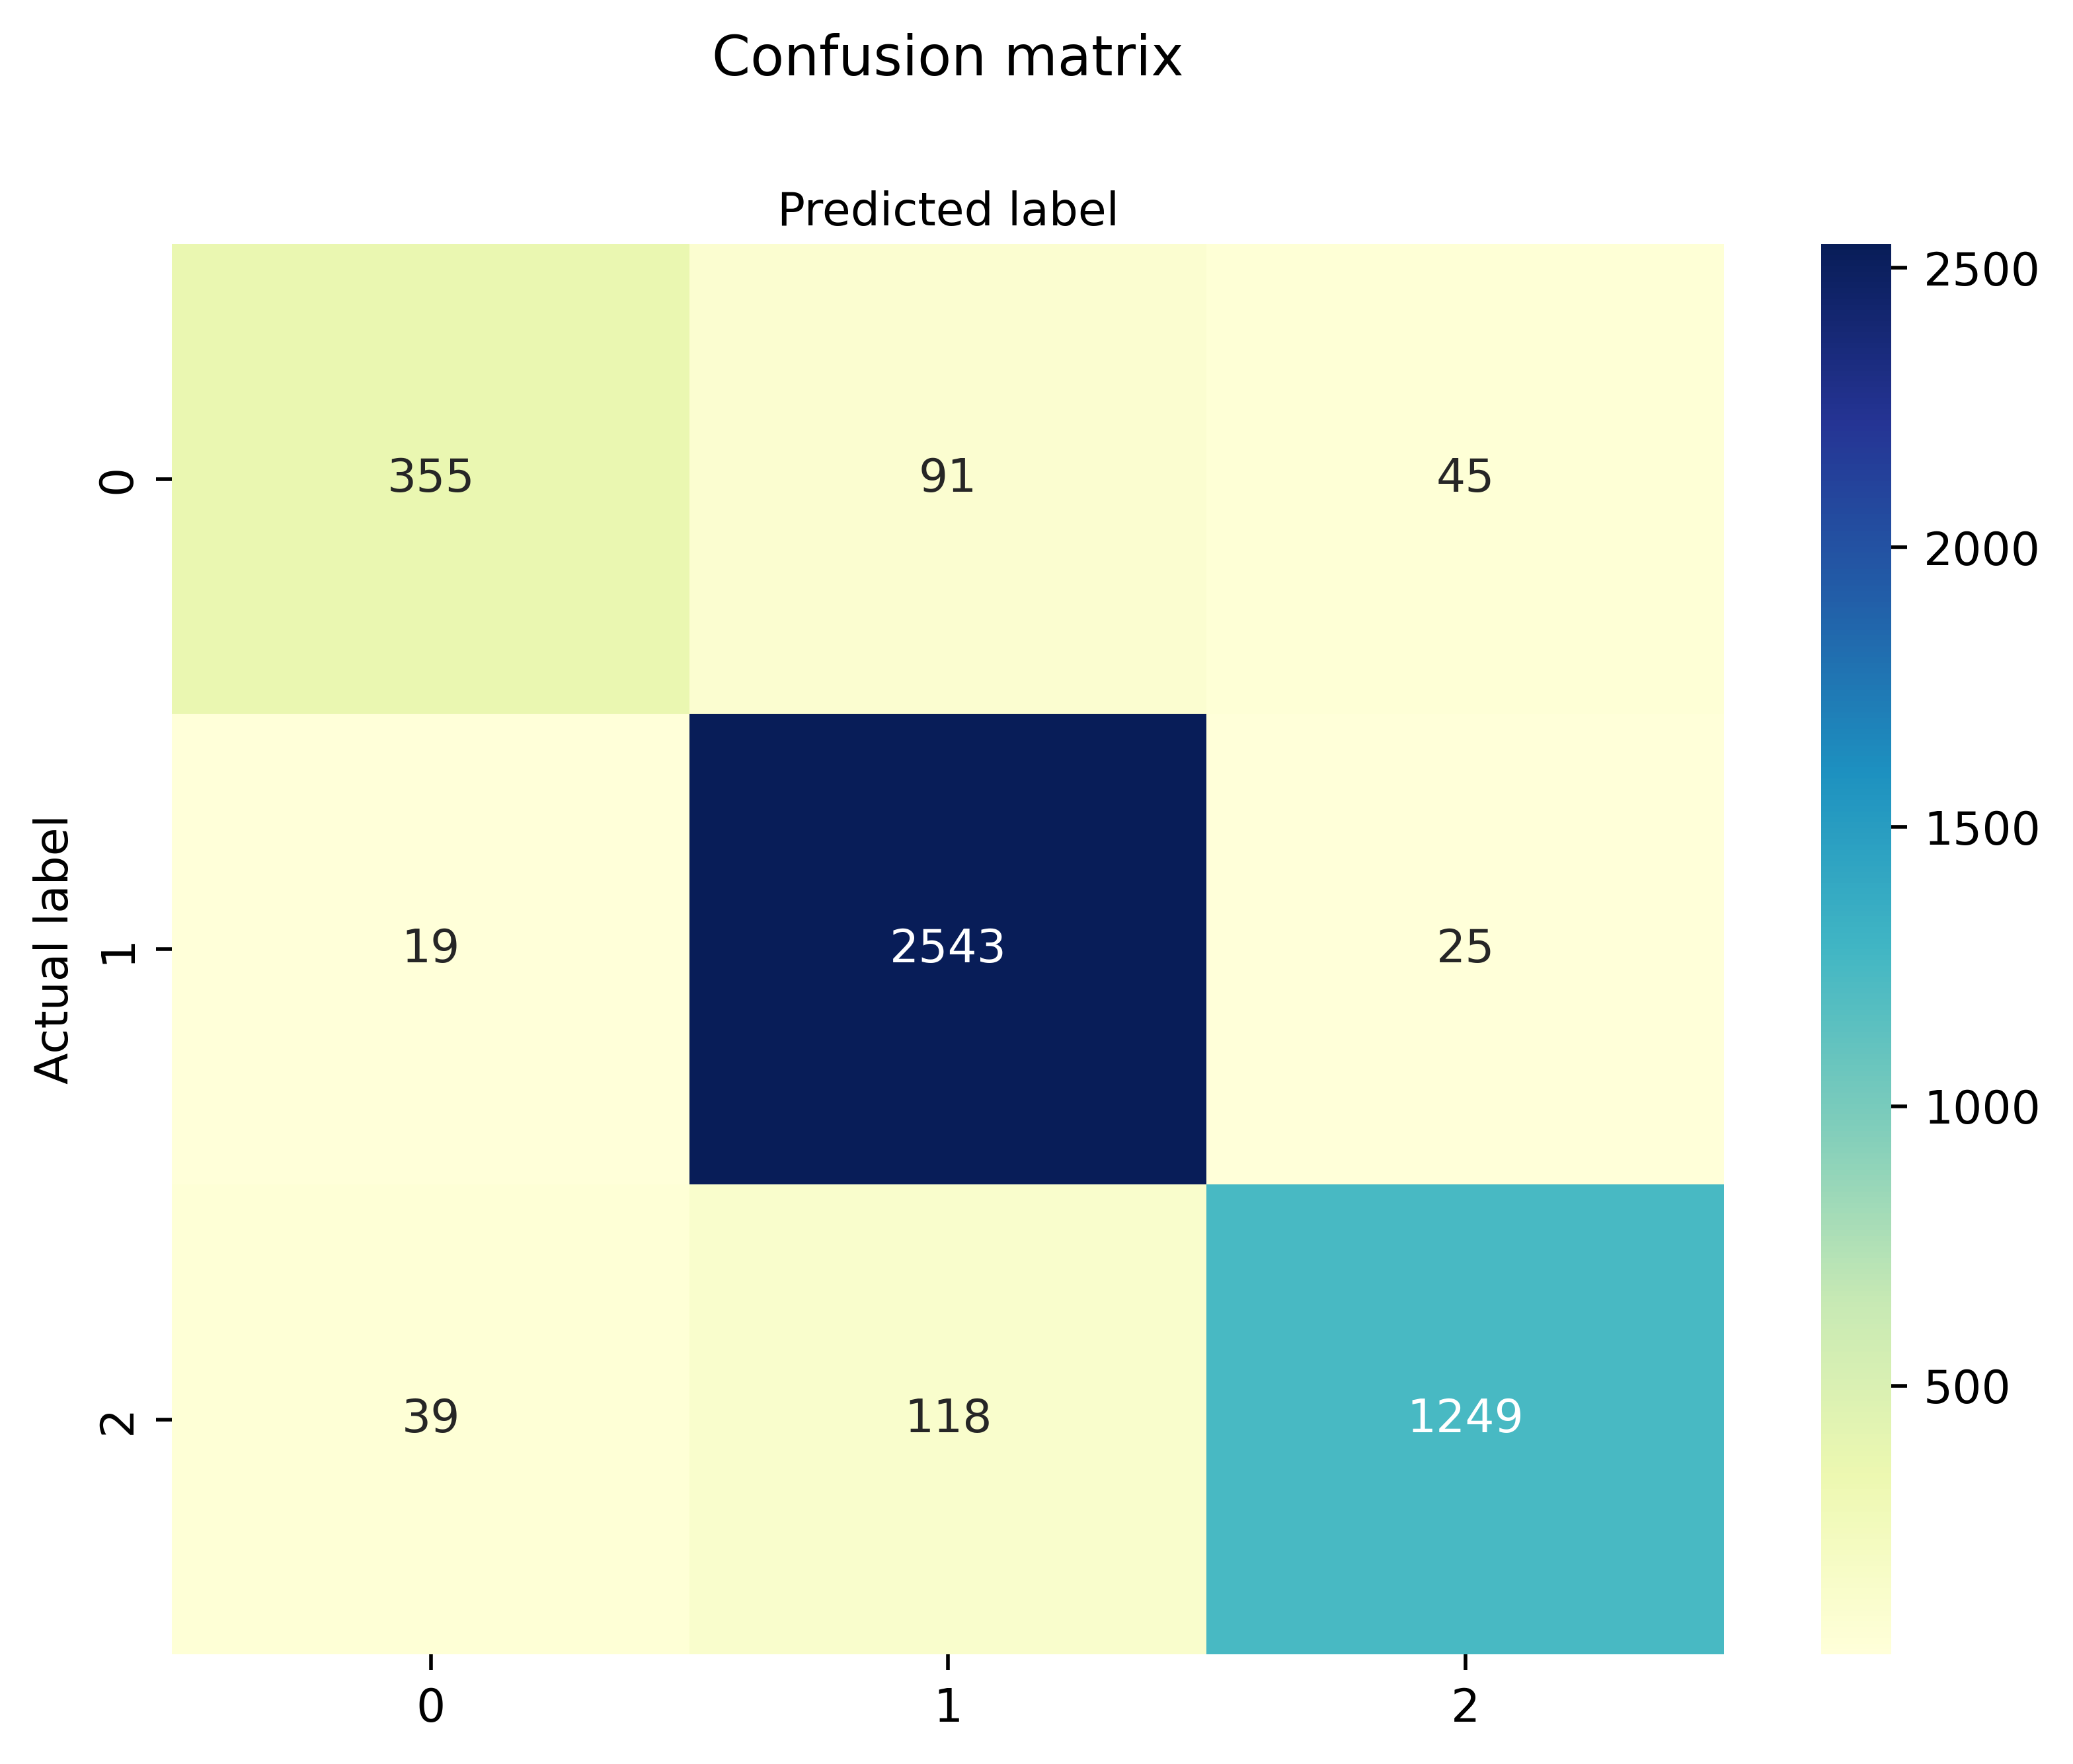

In [63]:
# Predict and evaluate the model
predictions_gb = gradient_boosting_classifier.predict(features_test_bow_combined)
accuracy_gb = accuracy_score(target_test, predictions_gb)
print(f"Accuracy: {accuracy_gb}")

# Calculate OOB Score
oob_score_gb = gradient_boosting_classifier.score(features_train_bow_combined, target_train)
print(f"\nOOB Score: {oob_score_gb}")

# Detailed classification report for Gradient Boosting Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_gb))

# Print and Plot Confusion Matrix for Gradient Boosting Classifier
cm_gb = confusion_matrix(target_test, predictions_gb)
df_cm_gb = pd.DataFrame(cm_gb, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_gb)
plot_conf_mat(cm_gb)

## Voting Classifier

In [64]:
# Define individual Random Forest classifiers for a voting ensemble
rf_classifier1 = RandomForestClassifier(n_estimators=100)
rf_classifier2 = RandomForestClassifier(n_estimators=70)
rf_classifier3 = RandomForestClassifier(n_estimators=80)

# Create and train a Voting Classifier with the defined Random Forest models
voting_classifier = VotingClassifier(estimators=[
    ('rf1', rf_classifier1),
    ('rf2', rf_classifier2),
    ('rf3', rf_classifier3)
])
voting_classifier.fit(features_train_bow_combined, target_train)


VotingClassifier(estimators=[('rf1', RandomForestClassifier()),
                             ('rf2', RandomForestClassifier(n_estimators=70)),
                             ('rf3', RandomForestClassifier(n_estimators=80))])

Accuracy: 0.9239518287243532

OOB Score: 0.9976021859142363

Classification Report: 
               precision    recall  f1-score   support

          -1       0.89      0.74      0.81       491
           0       0.94      0.96      0.95      2587
           1       0.91      0.92      0.91      1406

    accuracy                           0.92      4484
   macro avg       0.91      0.87      0.89      4484
weighted avg       0.92      0.92      0.92      4484

Confusion Matrix:
      -1     0     1
-1  361    75    55
0    20  2494    73
1    24    94  1288


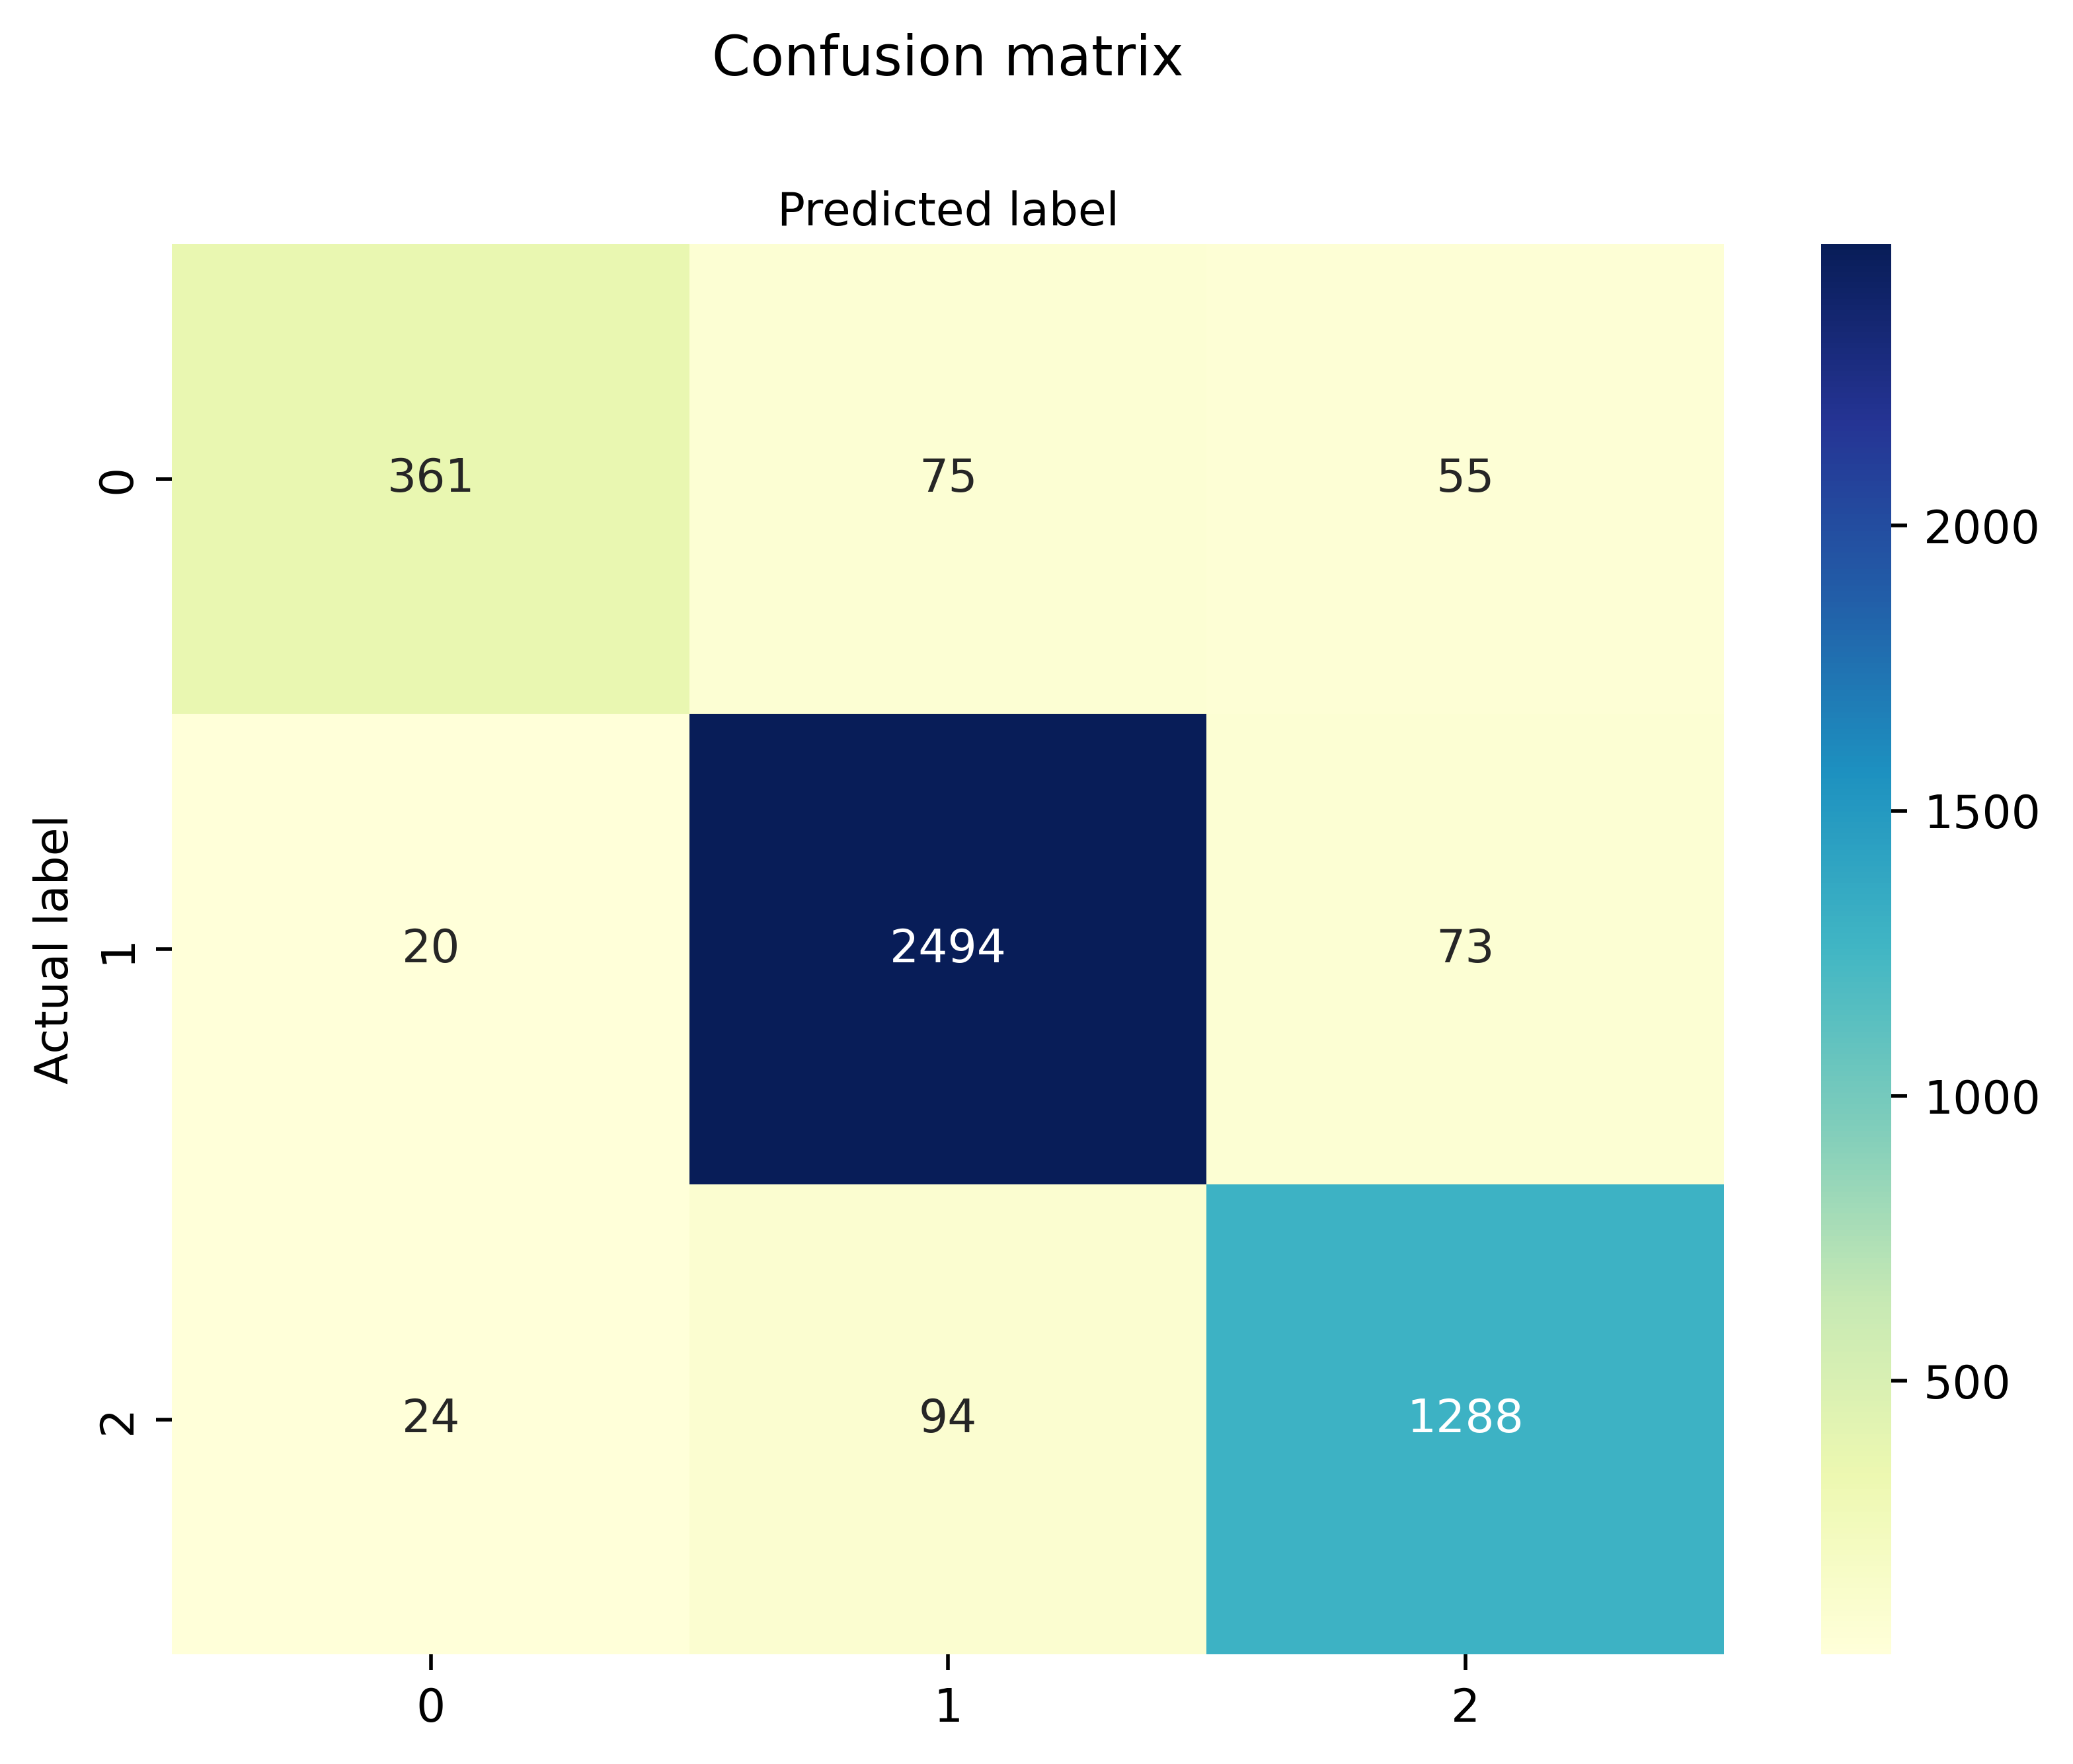

In [65]:
# Make predictions with the Voting Classifier and evaluate
predictions_voting = voting_classifier.predict(features_test_bow_combined)
accuracy_voting = accuracy_score(target_test, predictions_voting)
print(f"Accuracy: {accuracy_voting}")

# Calculate OOB Score
oob_score_voting = voting_classifier.score(features_train_bow_combined, target_train)
print(f"\nOOB Score: {oob_score_voting}")

# Detailed classification report for Voting Classifier
print("\nClassification Report: \n", classification_report(target_test, predictions_voting))

# Print and Plot Confusion Matrix for Voting Classifier
cm_voting = confusion_matrix(target_test, predictions_voting)
df_cm_voting = pd.DataFrame(cm_voting, index=['-1', '0', '1'], columns=['-1', '0', '1'])
print("Confusion Matrix:\n", df_cm_voting)
plot_conf_mat(cm_voting)

# Repeated K-Fold Cross Validation

## Vanilla Random Forest Classifier

### TF-IDF

In [8]:
def evaluate_model(features, target, num_repeats):
    # Initialize the RandomForest classifier with out-of-bag estimates
    model = RandomForestClassifier(random_state=50, oob_score=True)
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)
    # Fit the model to get the OOB score
    model.fit(features, target)
    return scores, model.oob_score_

In [9]:
# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

Cross-Validation Repeats: 1, Mean Accuracy: 0.9208, SEM: 0.002, OOB Score: 0.9229
Cross-Validation Repeats: 2, Mean Accuracy: 0.9219, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 3, Mean Accuracy: 0.9221, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 4, Mean Accuracy: 0.9218, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 5, Mean Accuracy: 0.9216, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 6, Mean Accuracy: 0.9218, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 7, Mean Accuracy: 0.9218, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 8, Mean Accuracy: 0.9220, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 9, Mean Accuracy: 0.9221, SEM: 0.001, OOB Score: 0.9229


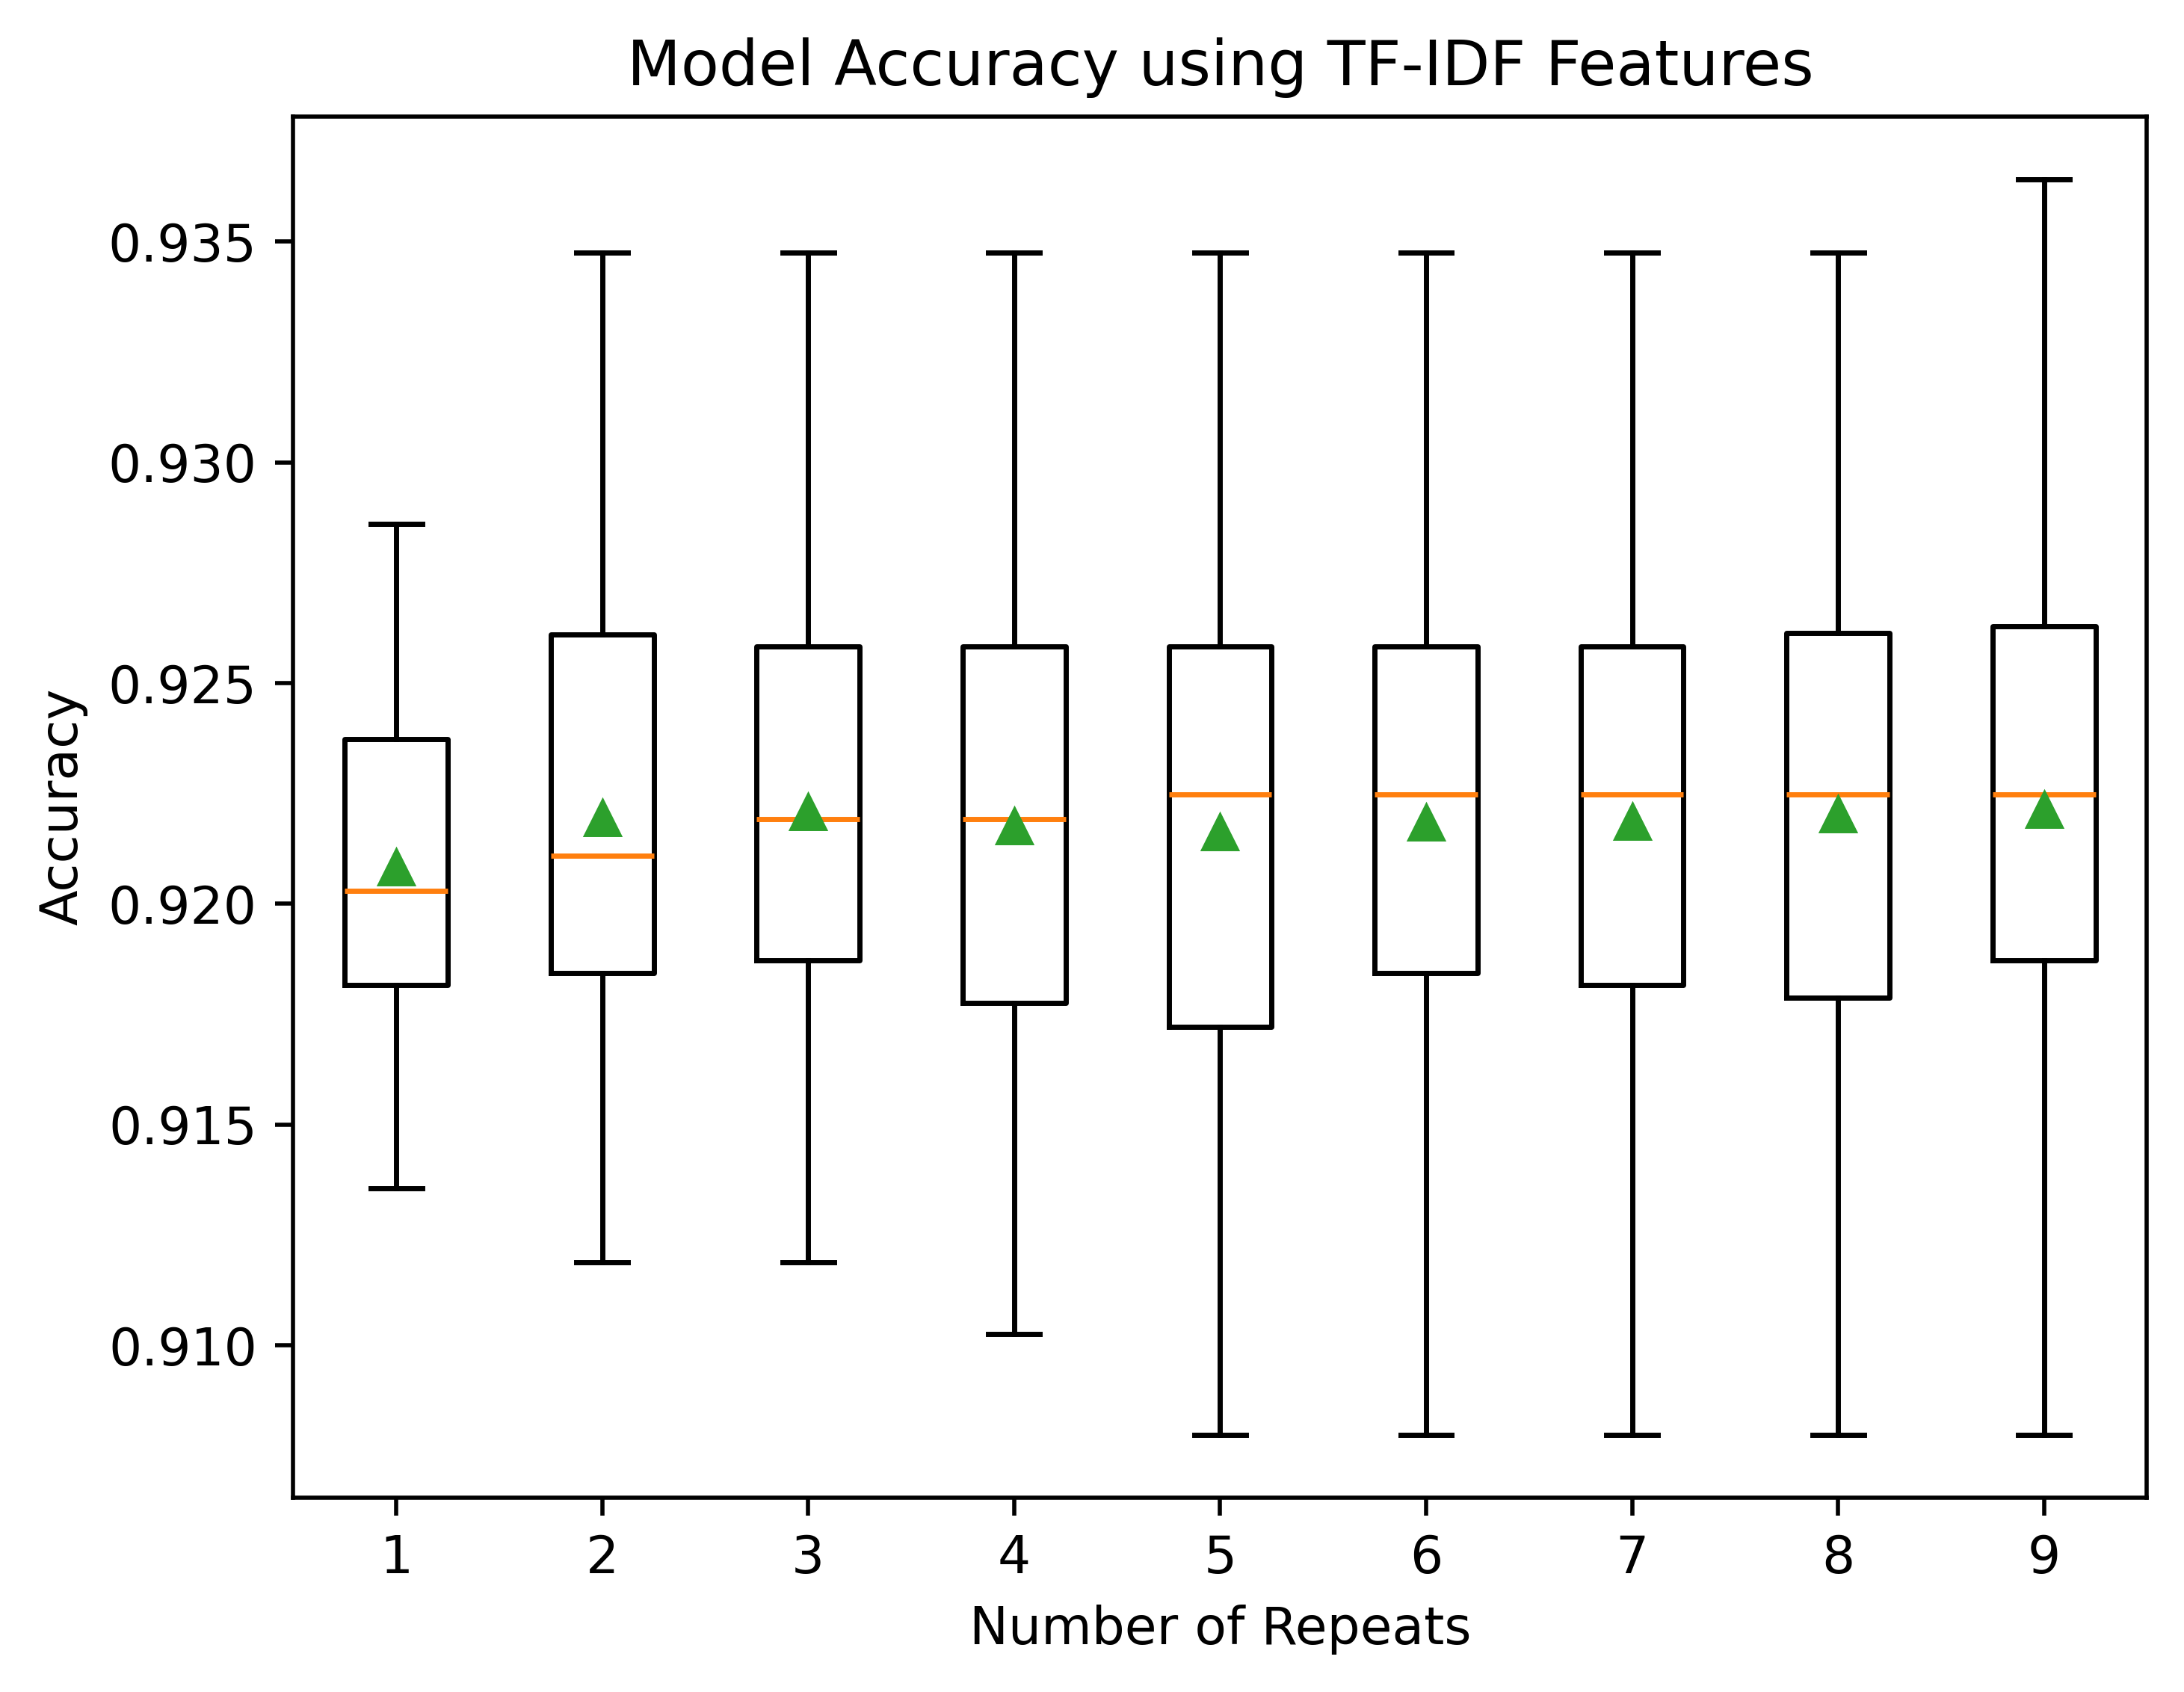

In [10]:
results = []  # List to store the results of each evaluation

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores, oob_score = evaluate_model(features_train_tfidf_combined, target_train, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}, OOB Score: {oob_score:.4f}')
    # Store the results
    results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_vanilla_tfidf"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/145/{model}.csv', index=False)

### BoW

Cross-Validation Repeats: 1, Mean Accuracy: 0.9222, SEM: 0.002, OOB Score: 0.9233
Cross-Validation Repeats: 2, Mean Accuracy: 0.9225, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 3, Mean Accuracy: 0.9228, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 4, Mean Accuracy: 0.9226, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 5, Mean Accuracy: 0.9226, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 6, Mean Accuracy: 0.9227, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 7, Mean Accuracy: 0.9230, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 8, Mean Accuracy: 0.9230, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 9, Mean Accuracy: 0.9229, SEM: 0.001, OOB Score: 0.9233


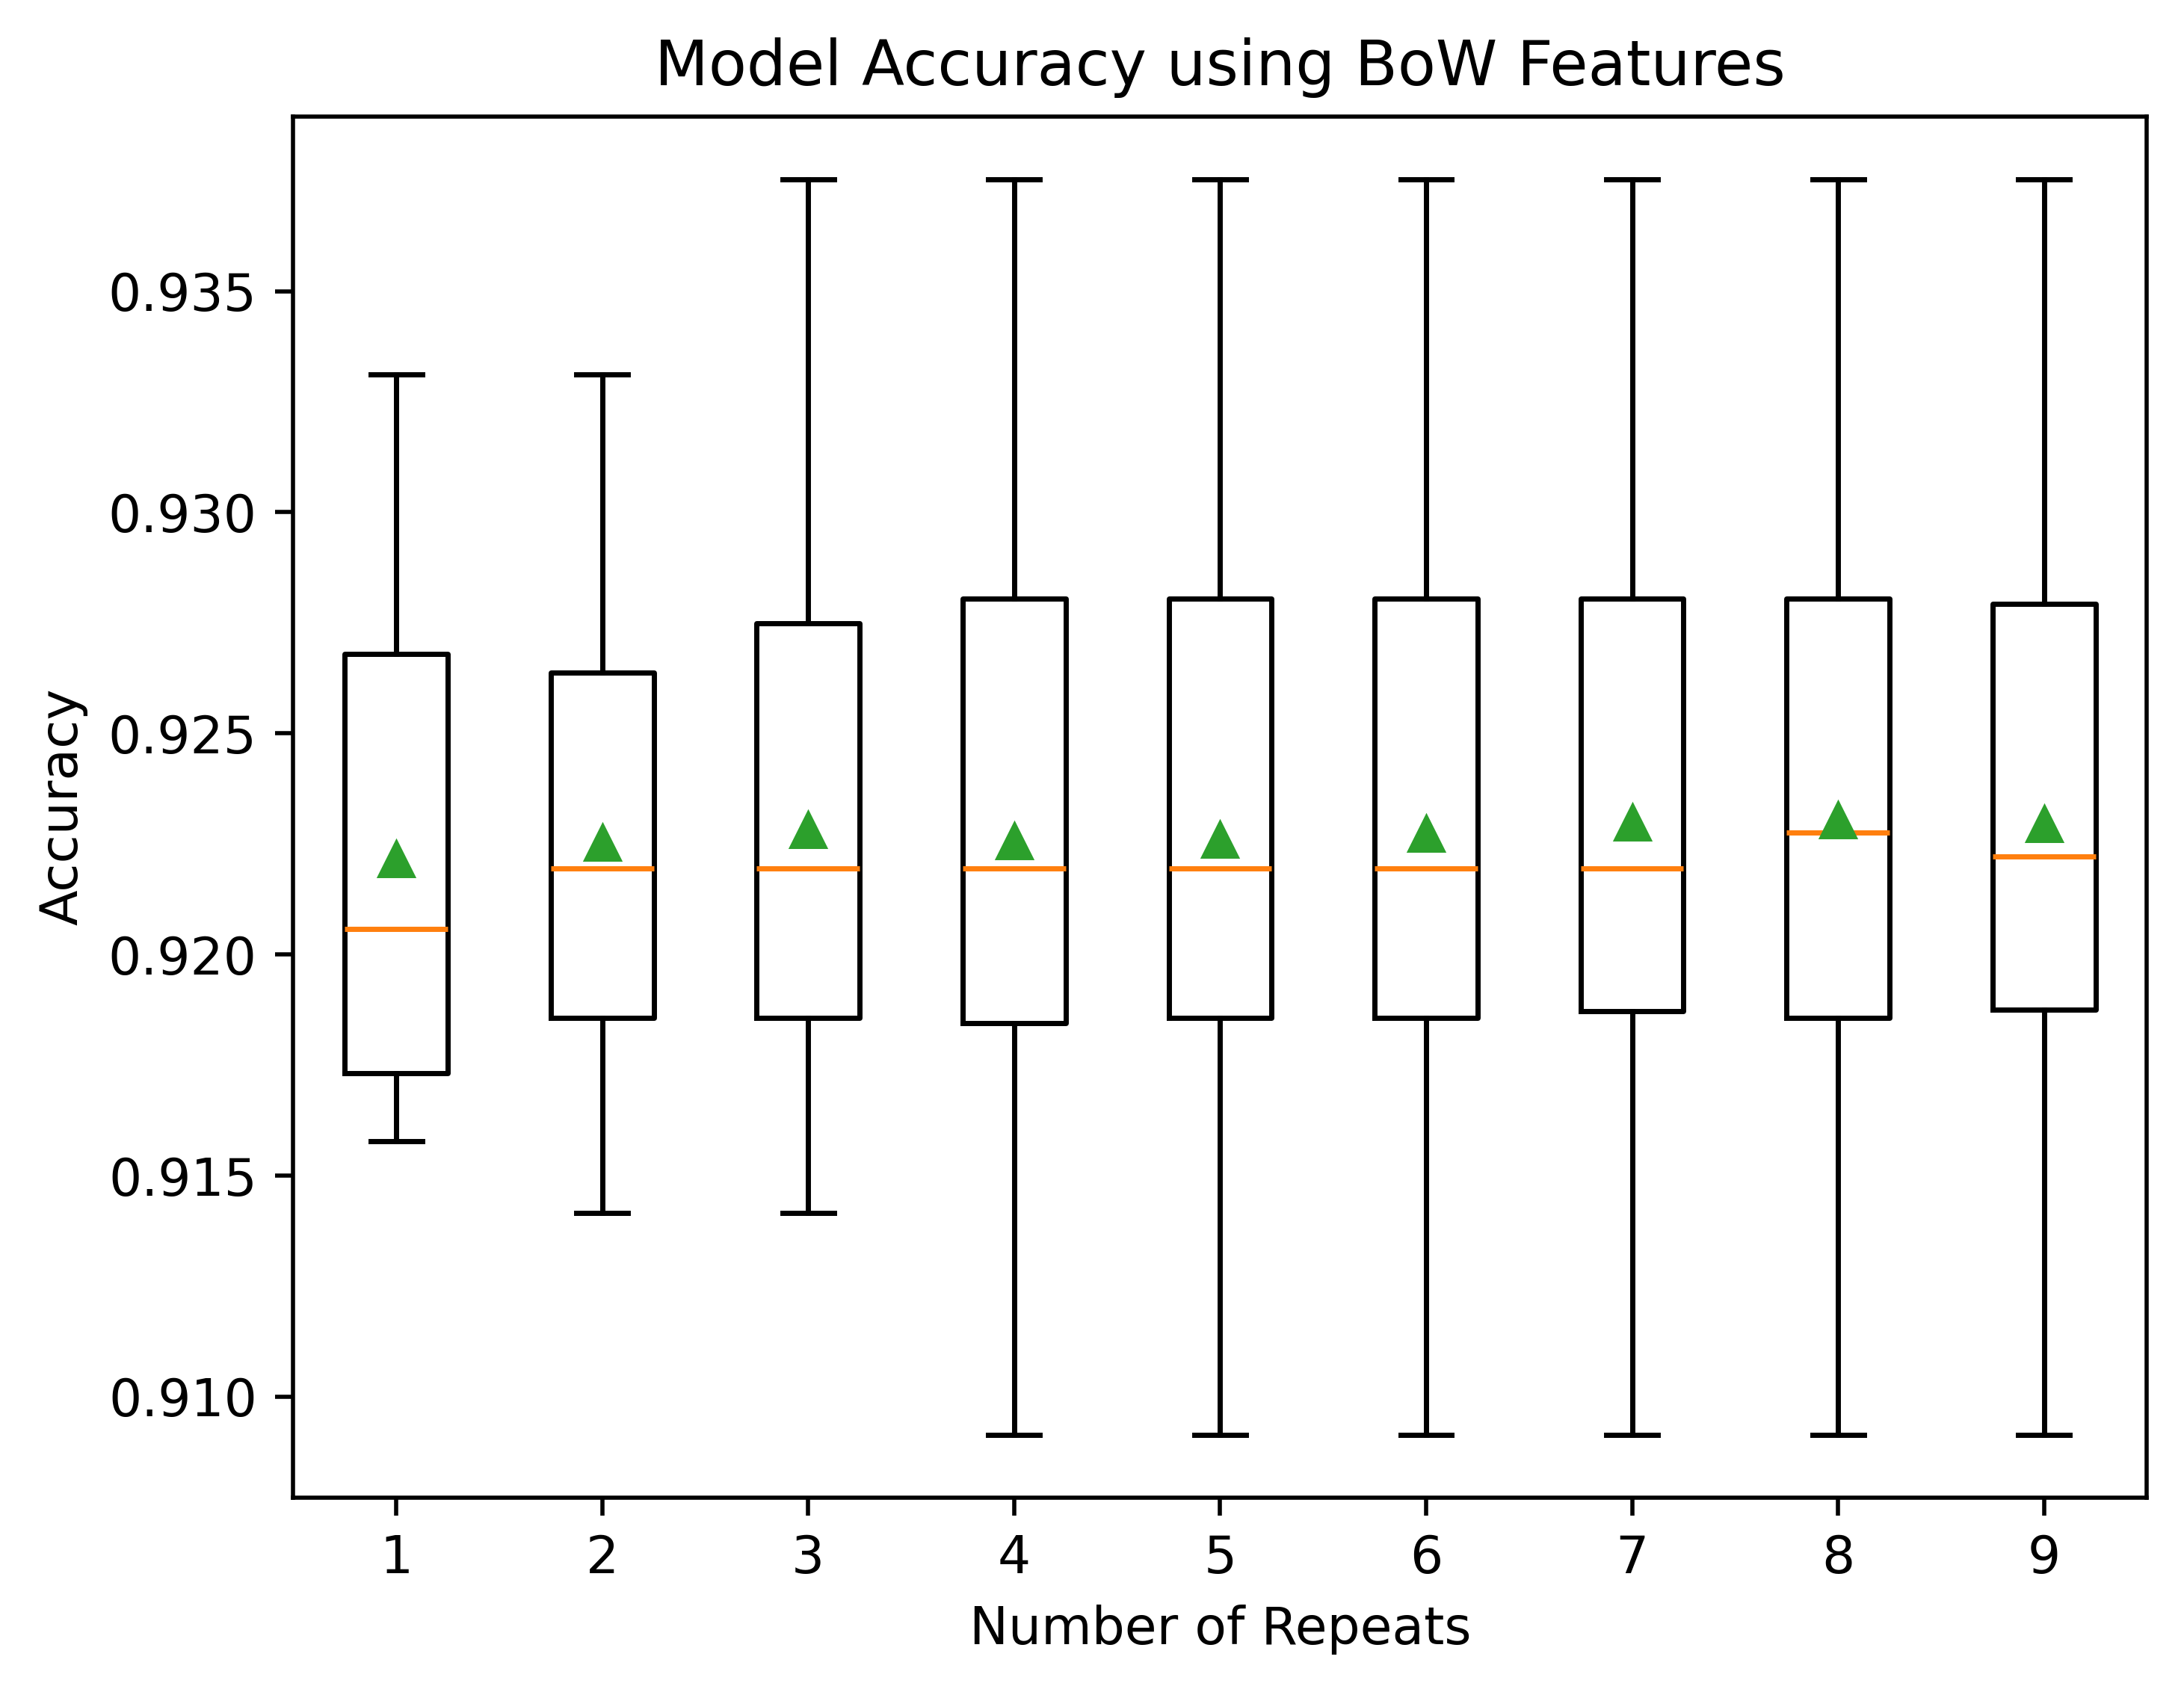

In [11]:
# Clear previous results
results = []

# Evaluate the model using BoW combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores, oob_score = evaluate_model(features_train_bow_combined, target_train, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}, OOB Score: {oob_score:.4f}')
    # Store the results
    results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_vanilla_bow"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/145/{model}.csv', index=False)

## Random Forest Classifier with Feature Bagging

### TF-IDF

In [12]:
def evaluate_model(features, target, num_repeats):
    # Initialize the RandomForest classifier with out-of-bag estimates
    model = RandomForestClassifier(max_features='sqrt', random_state=50, oob_score=True)
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)
    # Fit the model to get the OOB score
    model.fit(features, target)
    return scores, model.oob_score_

# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

Cross-Validation Repeats: 1, Mean Accuracy: 0.9208, SEM: 0.002, OOB Score: 0.9229
Cross-Validation Repeats: 2, Mean Accuracy: 0.9219, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 3, Mean Accuracy: 0.9221, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 4, Mean Accuracy: 0.9218, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 5, Mean Accuracy: 0.9216, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 6, Mean Accuracy: 0.9218, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 7, Mean Accuracy: 0.9218, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 8, Mean Accuracy: 0.9220, SEM: 0.001, OOB Score: 0.9229
Cross-Validation Repeats: 9, Mean Accuracy: 0.9221, SEM: 0.001, OOB Score: 0.9229


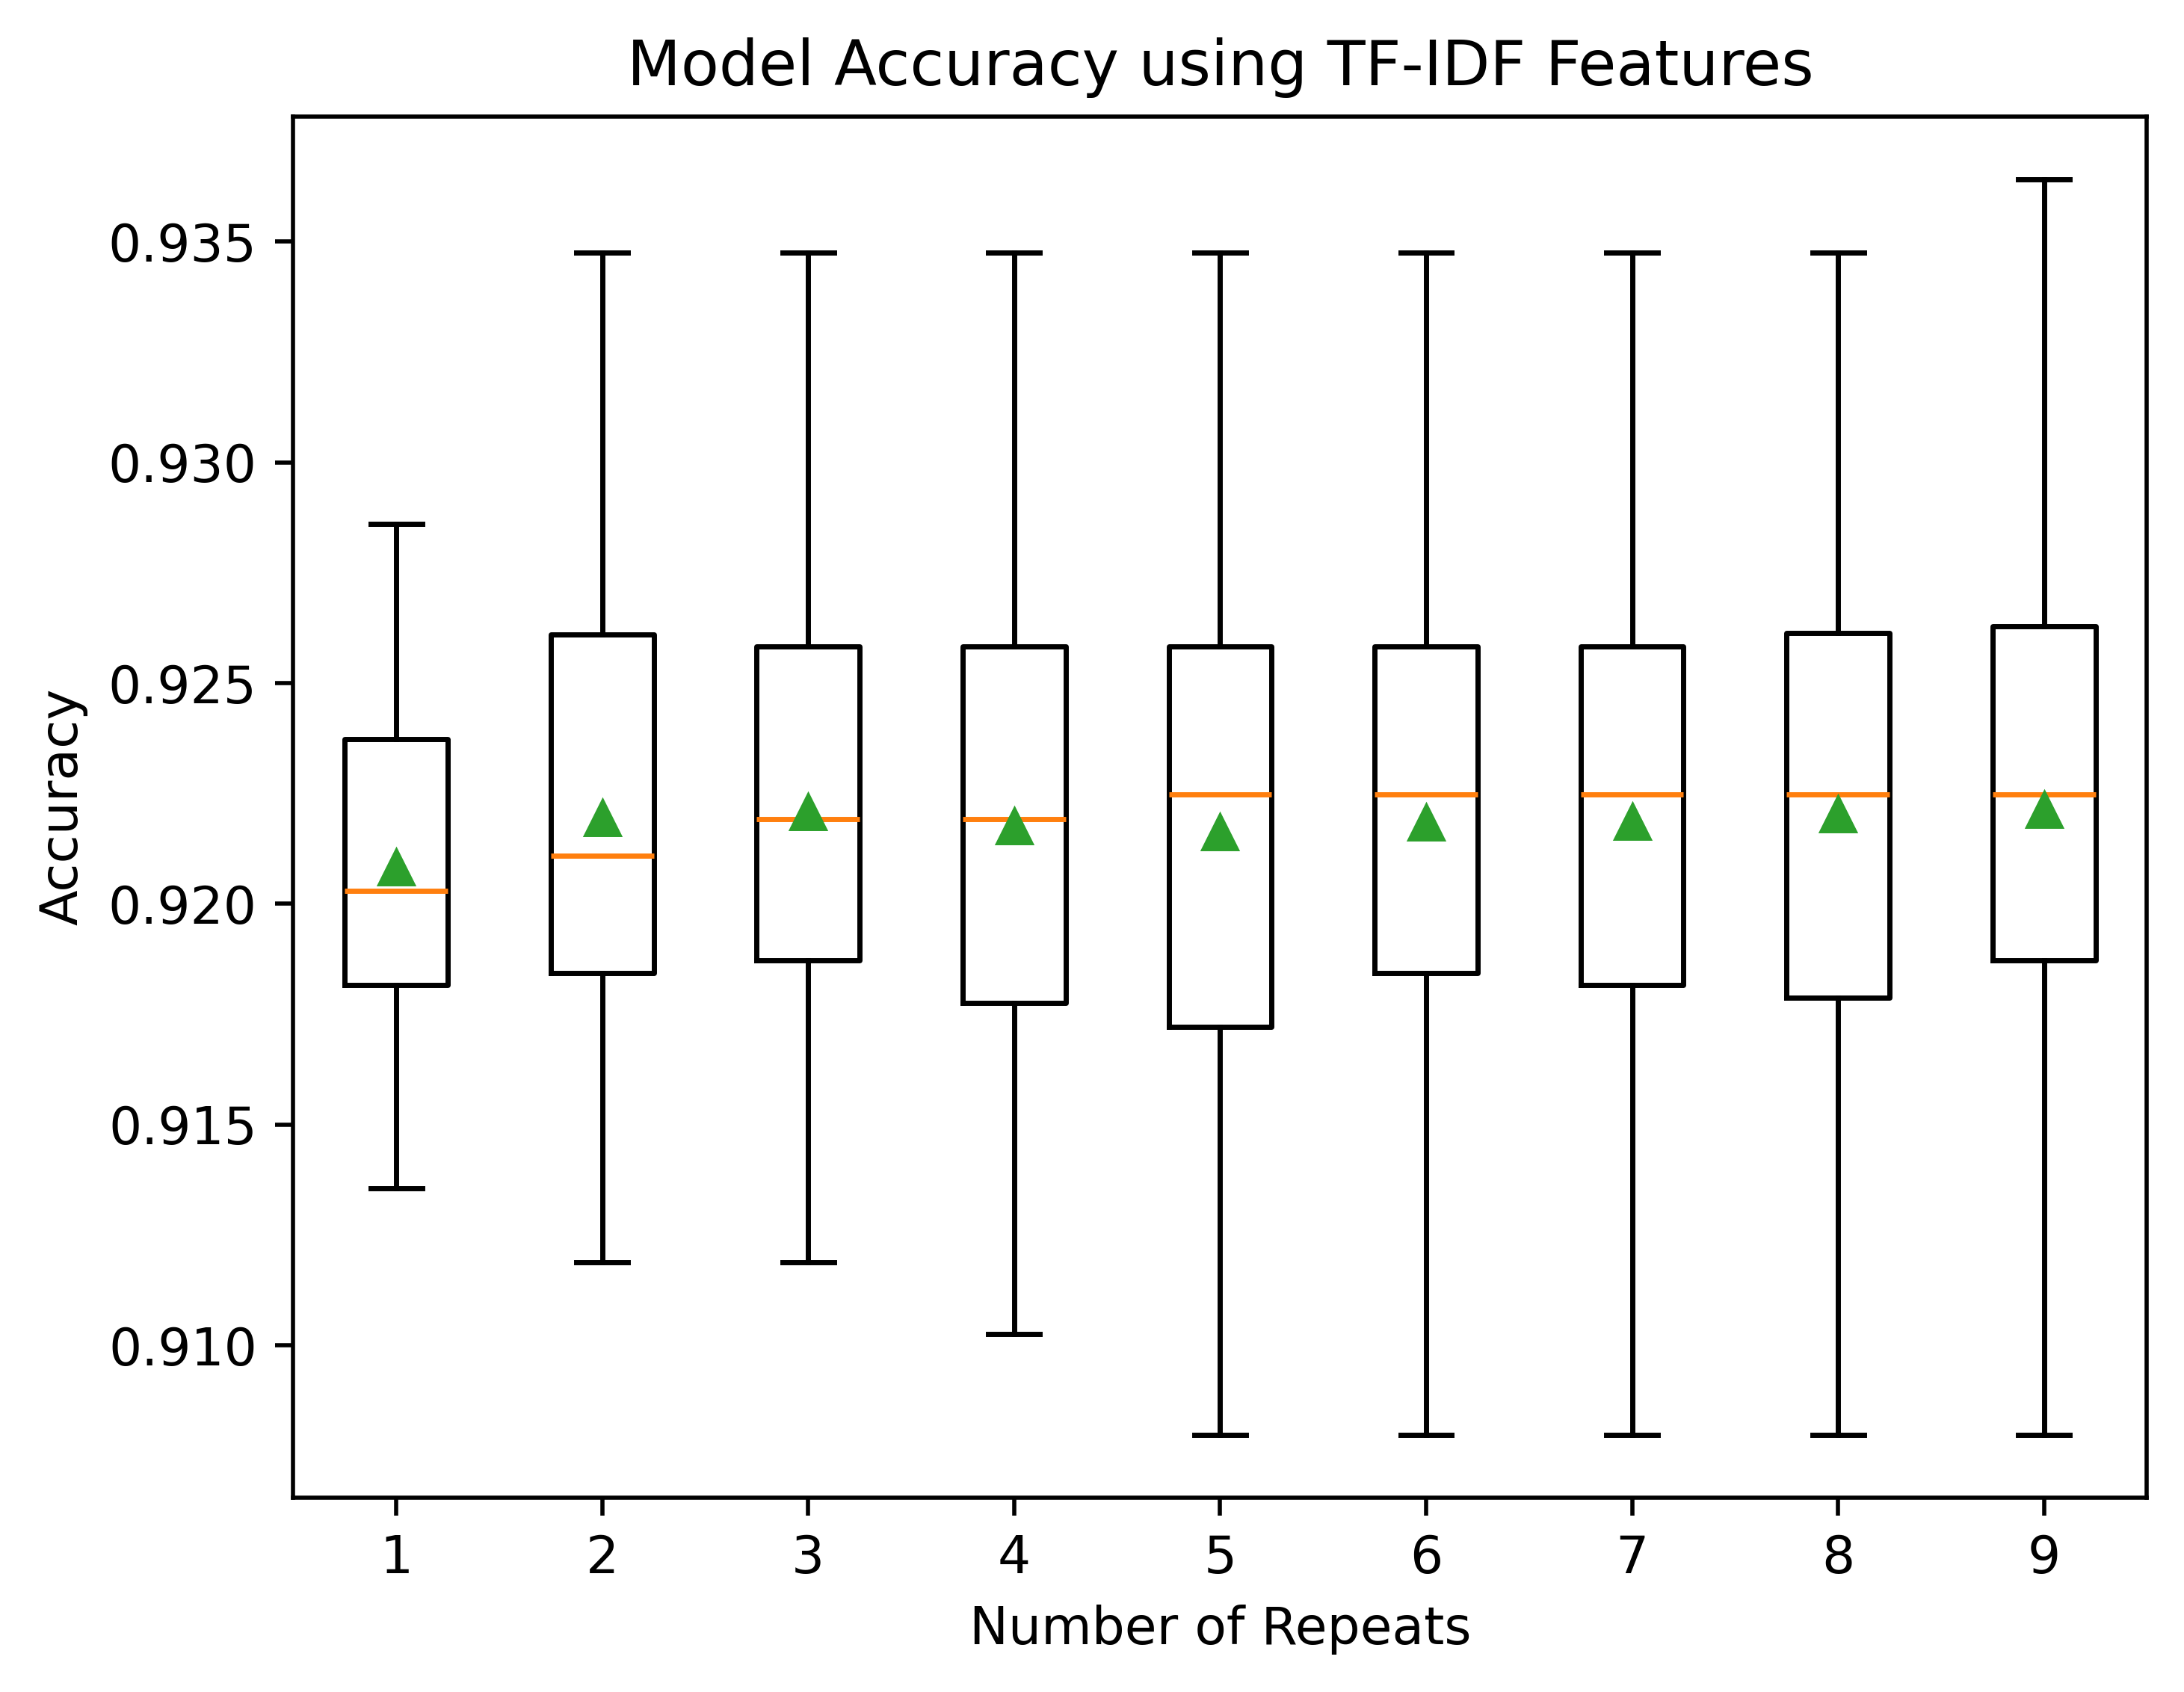

In [13]:
results = []  # List to store the results of each evaluation

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores, oob_score = evaluate_model(features_train_tfidf_combined, target_train, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}, OOB Score: {oob_score:.4f}')
    # Store the results
    results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_random_tfidf"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/145/{model}.csv', index=False)

### BoW

Cross-Validation Repeats: 1, Mean Accuracy: 0.9222, SEM: 0.002, OOB Score: 0.9233
Cross-Validation Repeats: 2, Mean Accuracy: 0.9225, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 3, Mean Accuracy: 0.9228, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 4, Mean Accuracy: 0.9226, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 5, Mean Accuracy: 0.9226, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 6, Mean Accuracy: 0.9227, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 7, Mean Accuracy: 0.9230, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 8, Mean Accuracy: 0.9230, SEM: 0.001, OOB Score: 0.9233
Cross-Validation Repeats: 9, Mean Accuracy: 0.9229, SEM: 0.001, OOB Score: 0.9233


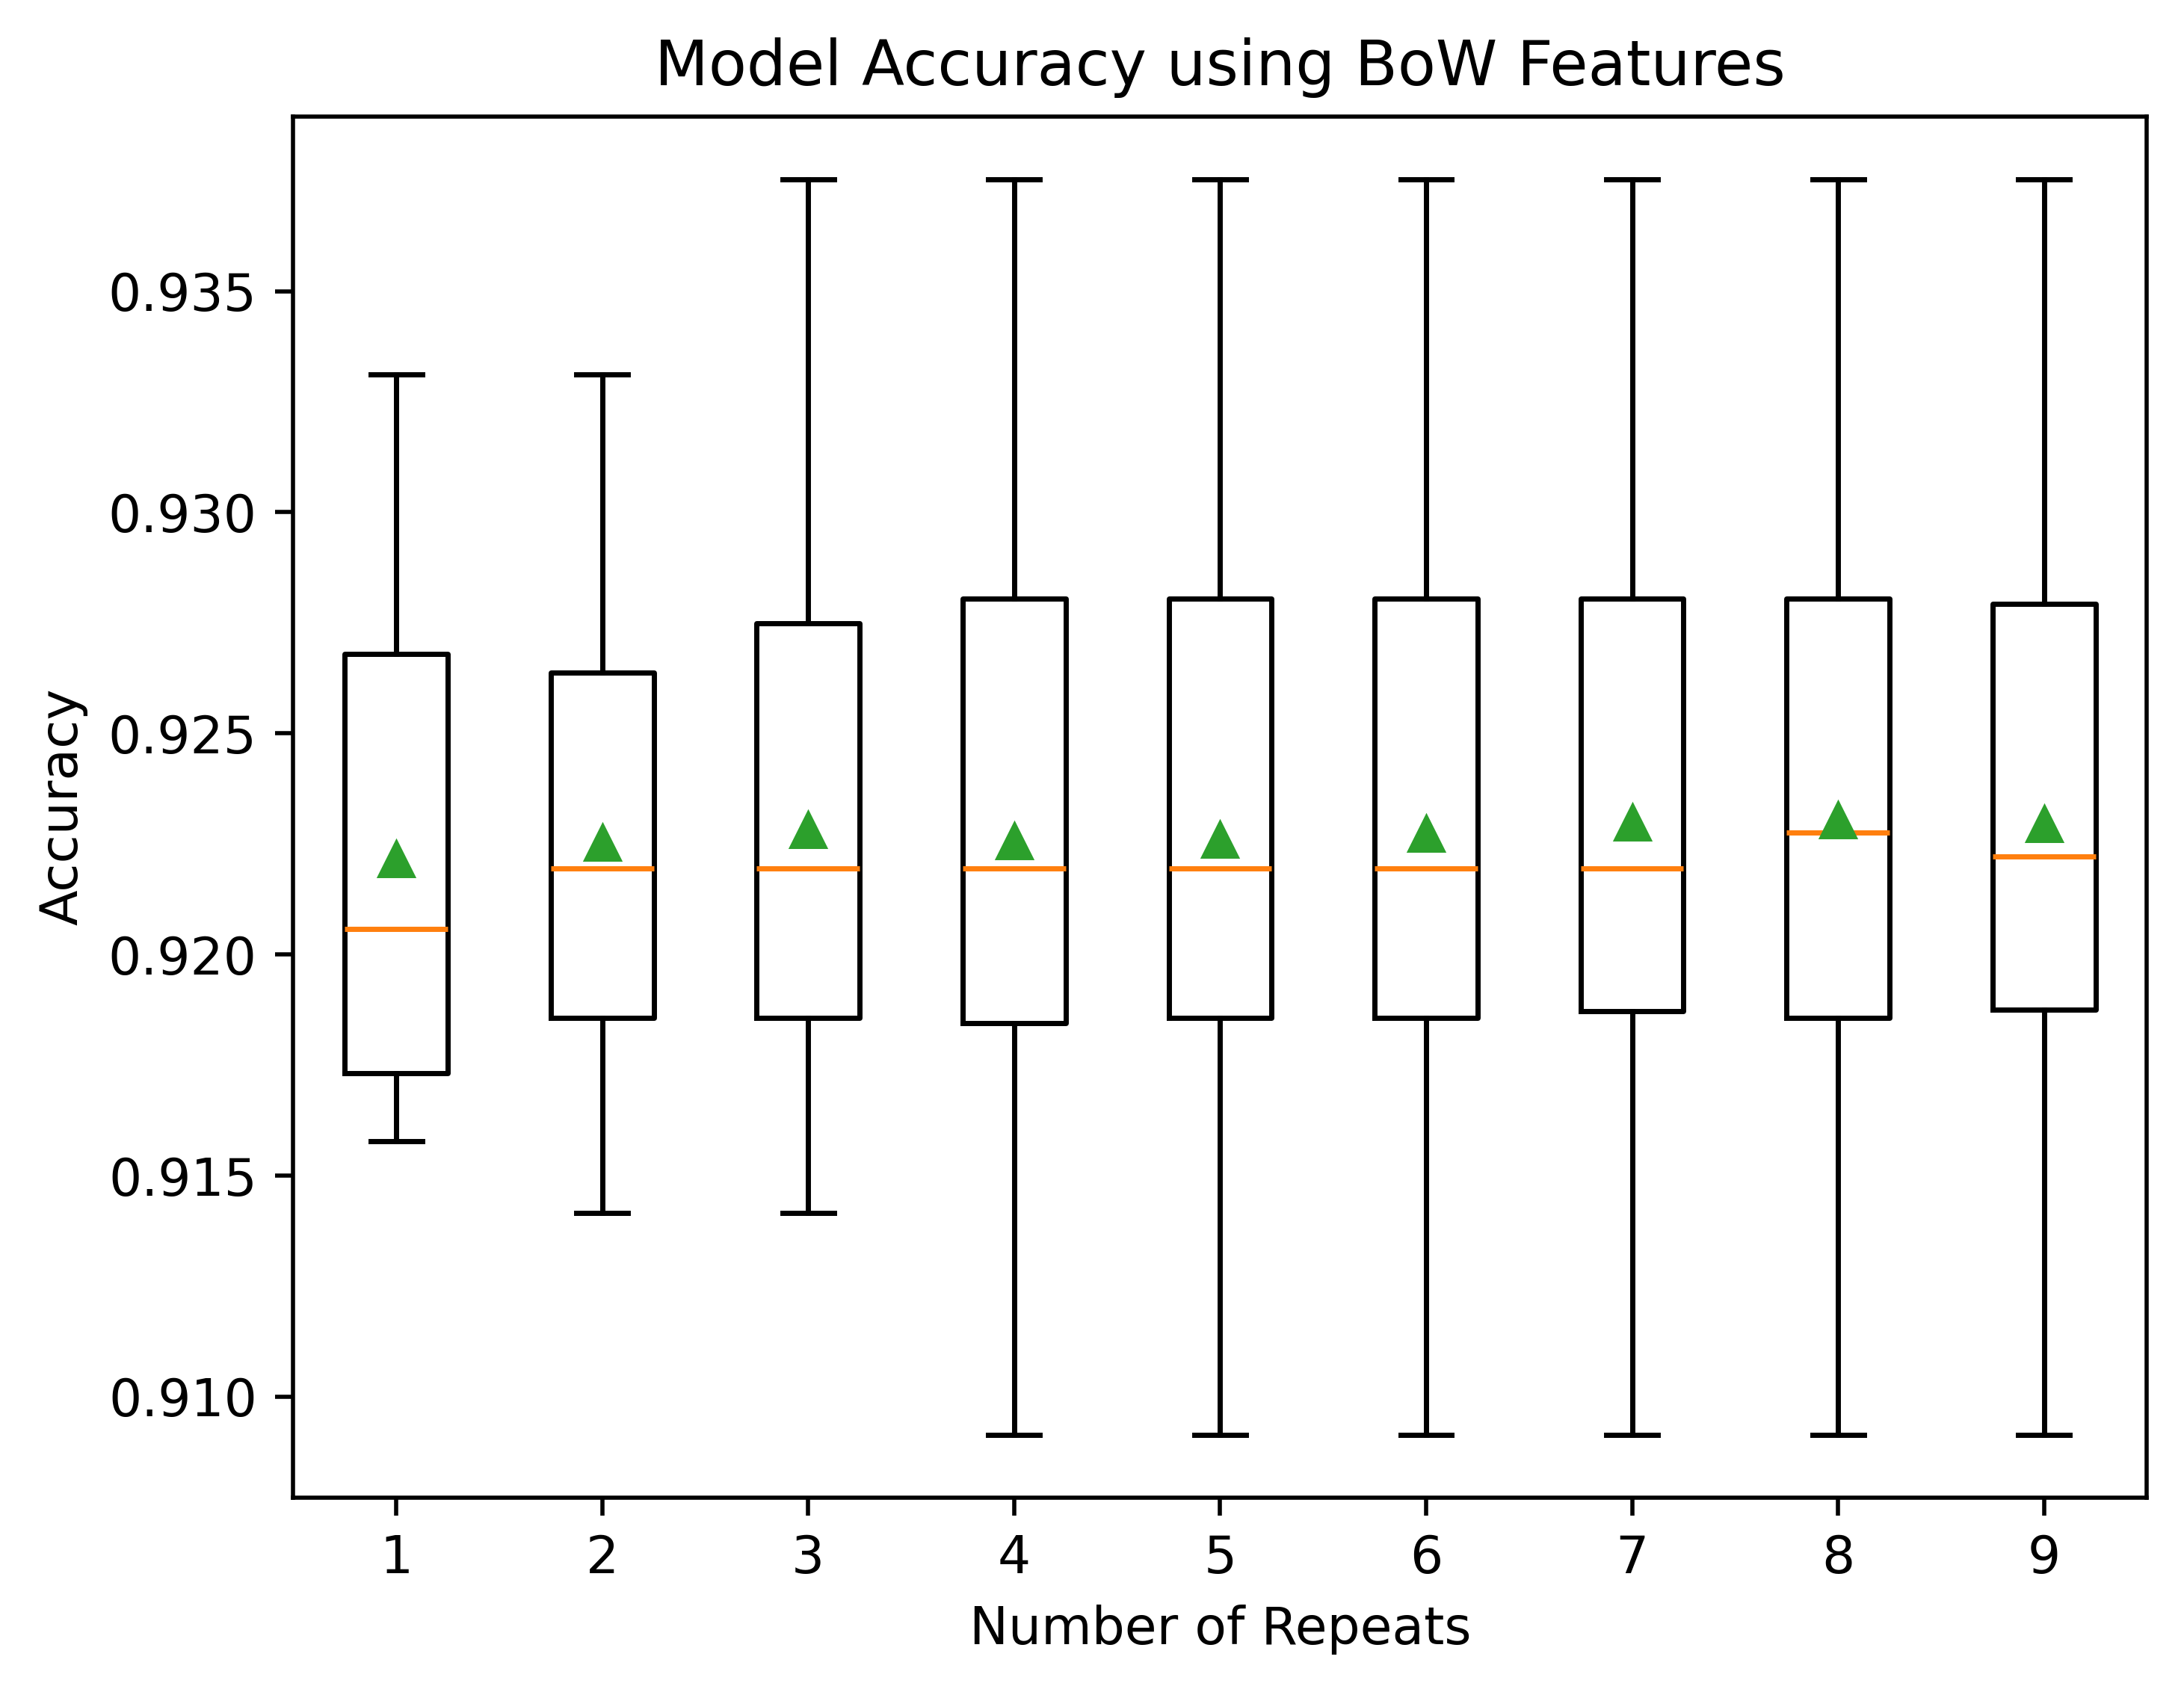

In [14]:
results = []  # List to store the results of each evaluation

# Evaluate the model using BoW combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores, oob_score = evaluate_model(features_train_bow_combined, target_train, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}, OOB Score: {oob_score:.4f}')
    # Store the results
    results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_random_bow"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/145/{model}.csv', index=False)

## Gradient Boosting Classifier

### TF-IDF

In [15]:
def evaluate_model(features, target, num_repeats):
    # Initialize the Gradient Boosting classifier
    model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_depth=10)
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

Cross-Validation Repeats: 1, Mean Accuracy: 0.9205, SEM: 0.002
Cross-Validation Repeats: 2, Mean Accuracy: 0.9196, SEM: 0.002
Cross-Validation Repeats: 3, Mean Accuracy: 0.9197, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9203, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9195, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9197, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9194, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9195, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9201, SEM: 0.001


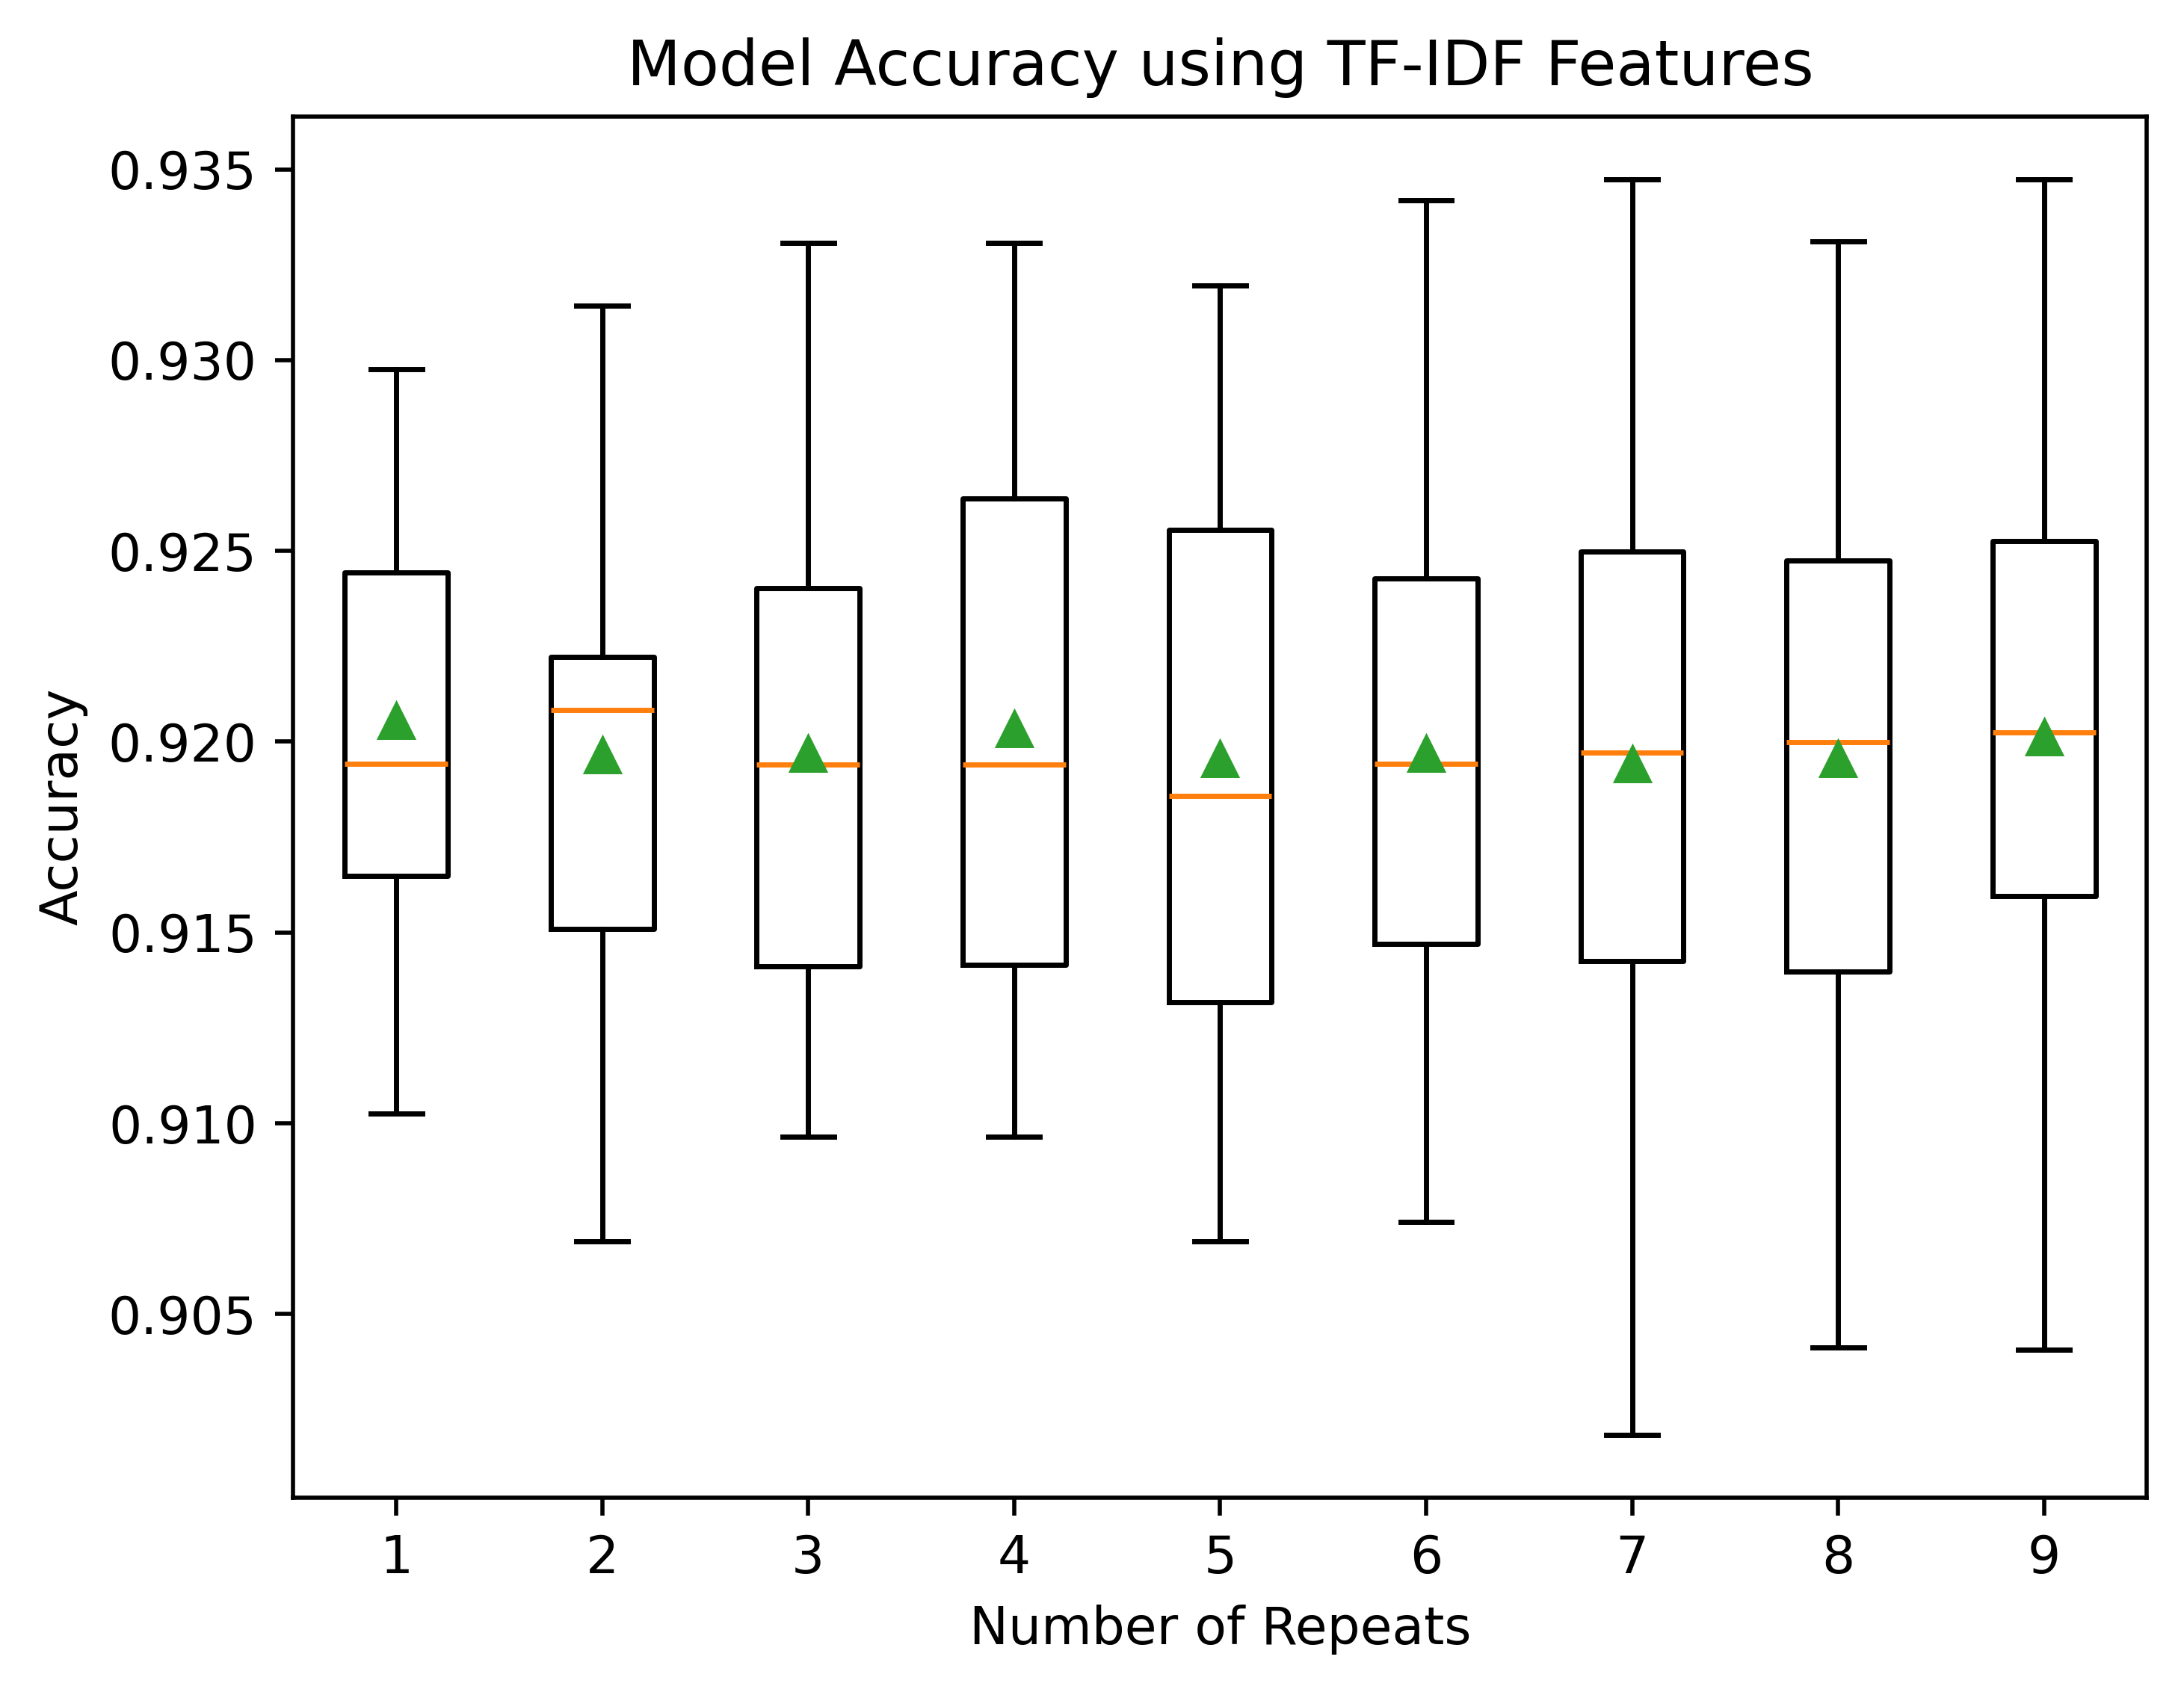

In [16]:
results = []  # List to store the results of each evaluation
mean_scores = []  # Store mean scores to summarize

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(features_train_tfidf_combined, target_train, r)
    # Summarize and print the mean accuracy and SEM
    mean_accuracy = np.mean(scores)
    accuracy_sem = sem(scores)
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {accuracy_sem:.3f}')
    # Store the results
    results.append(scores)
    mean_scores.append(mean_accuracy)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_gradient_tfidf"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/145/{model}.csv', index=False)

### BoW

Cross-Validation Repeats: 1, Mean Accuracy: 0.9243, SEM: 0.002
Cross-Validation Repeats: 2, Mean Accuracy: 0.9246, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9247, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9249, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9247, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9246, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9249, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9245, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9250, SEM: 0.001


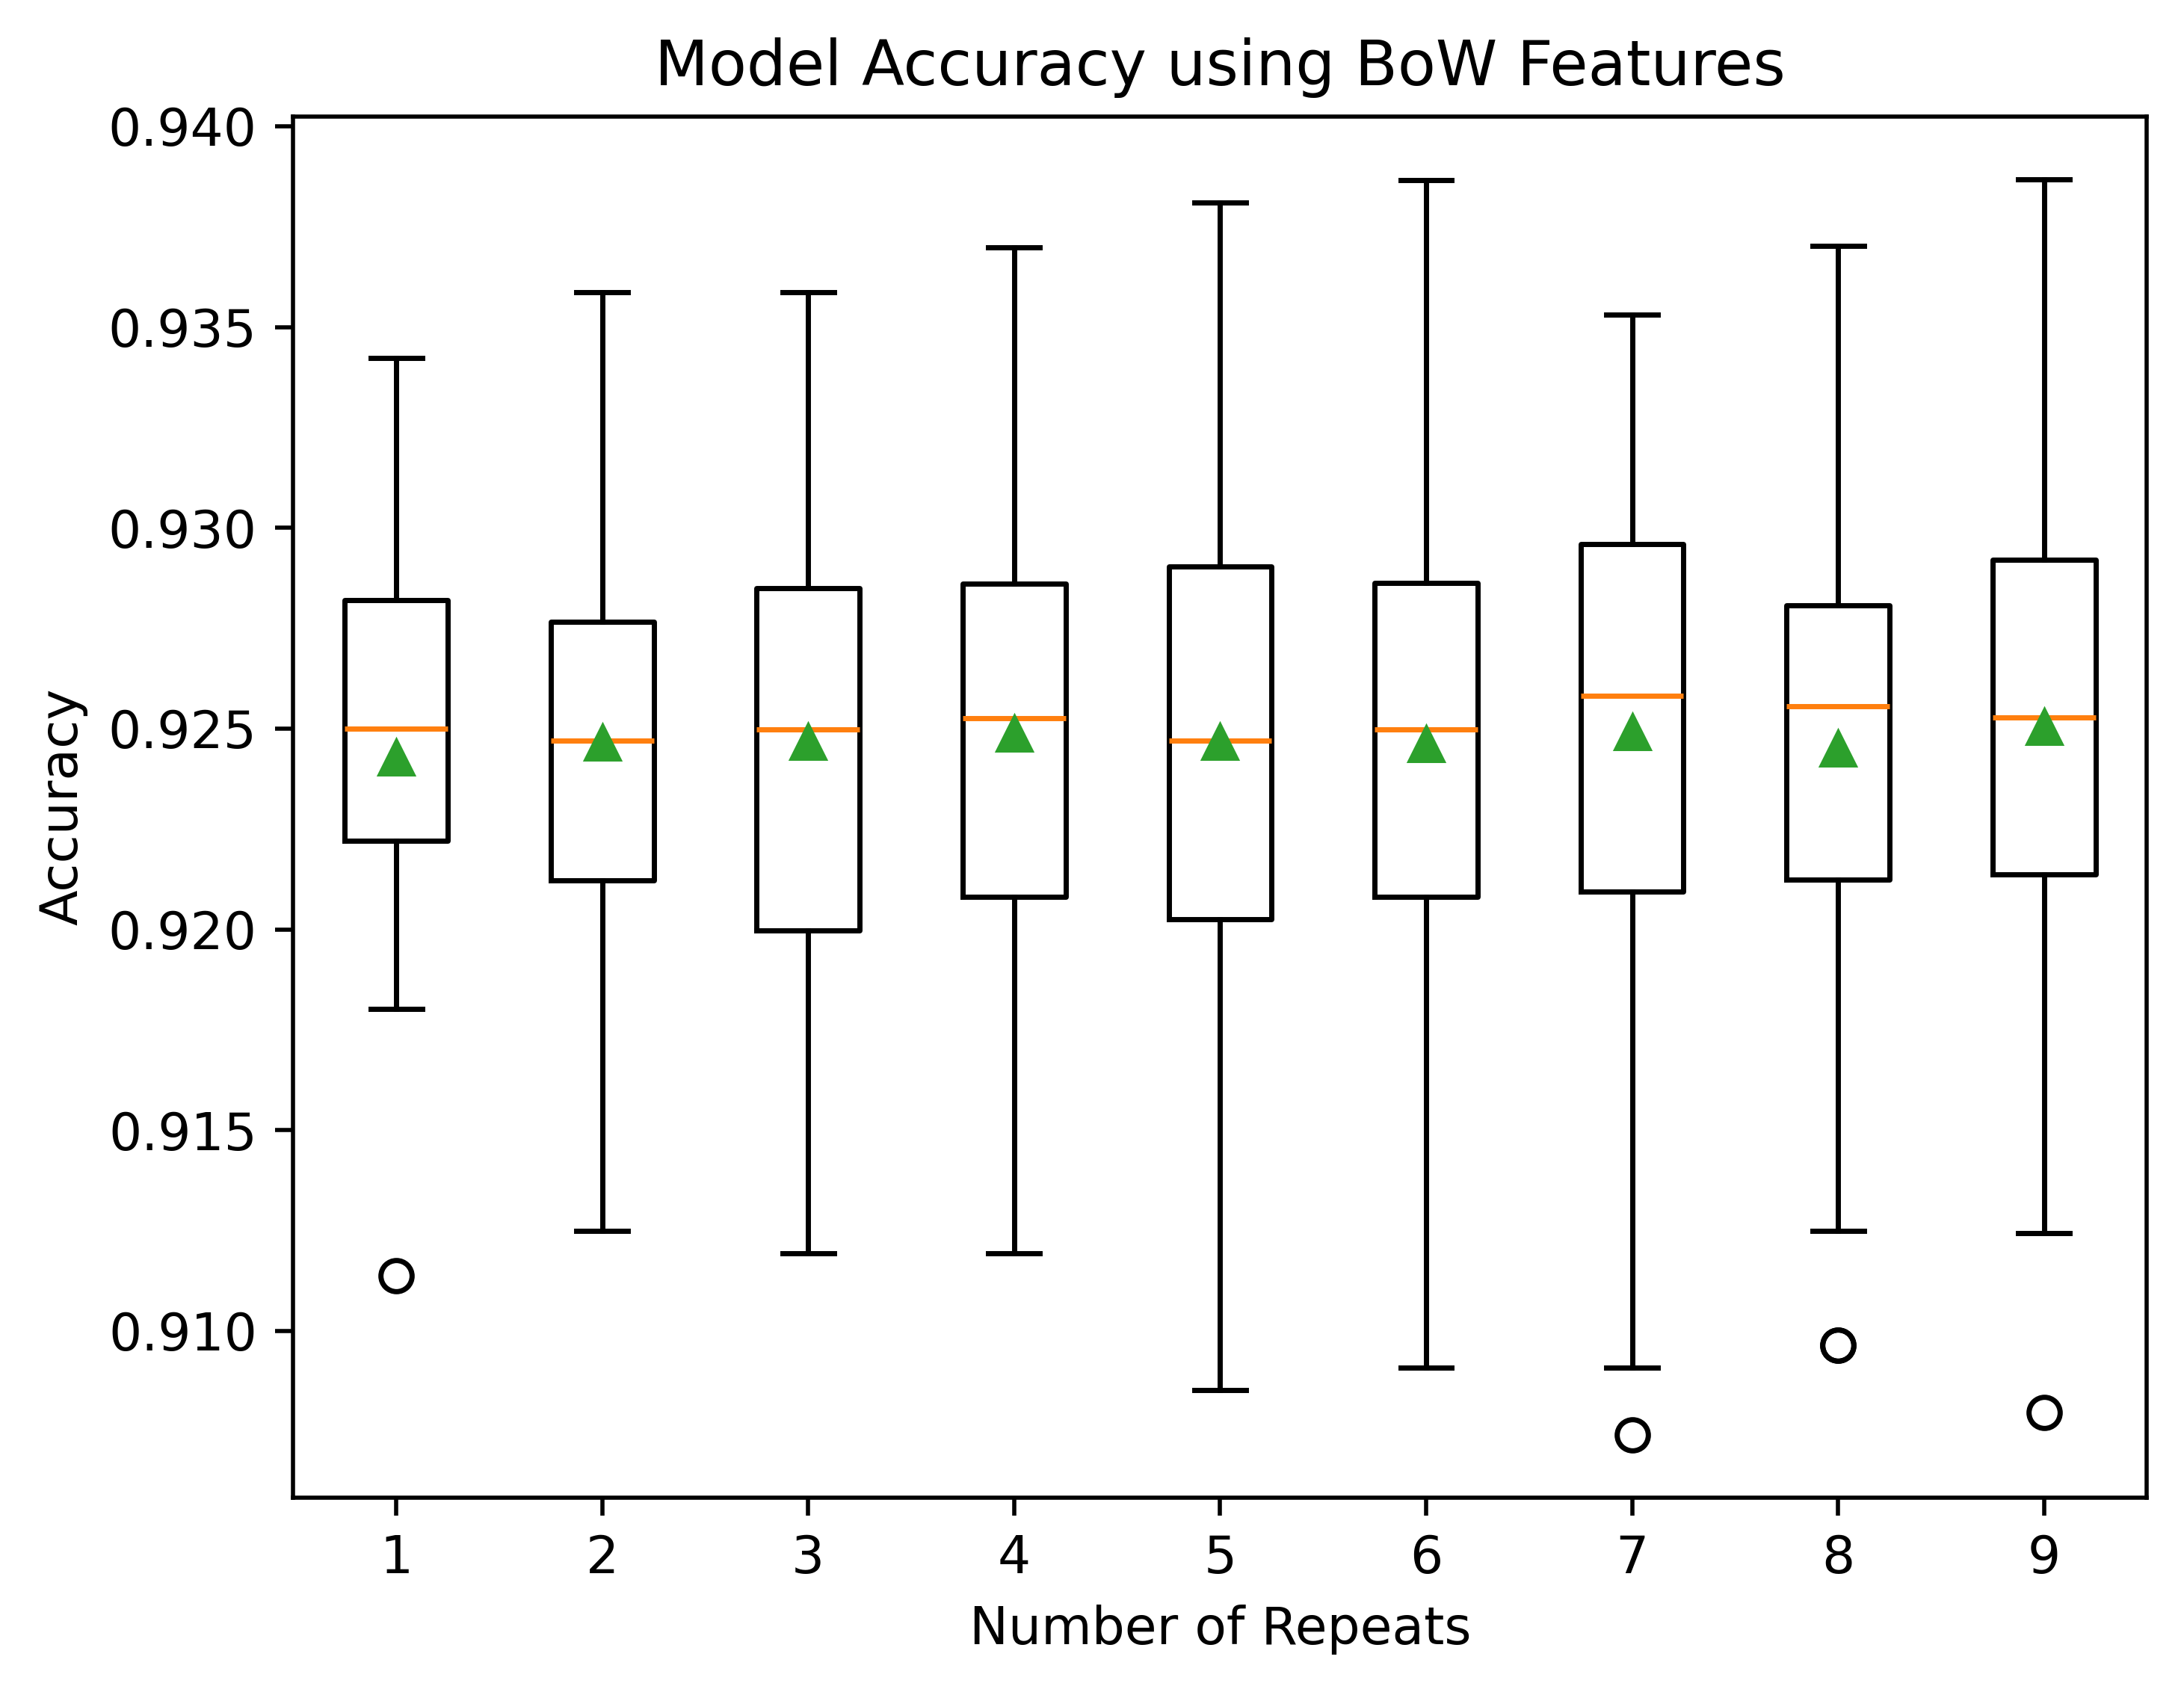

In [17]:
results = []  # List to store the results of each evaluation
mean_scores = []  # Store mean scores to summarize

# Evaluate the model using BoW combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(features_train_bow_combined, target_train, r)
    # Summarize and print the mean accuracy and SEM
    mean_accuracy = np.mean(scores)
    accuracy_sem = sem(scores)
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {accuracy_sem:.3f}')
    # Store the results
    results.append(scores)
    mean_scores.append(mean_accuracy)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_gradient_bow"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/145/{model}.csv', index=False)

## Voting Classifier

### TF-IDF

In [18]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

def evaluate_model(features, target, num_repeats):
    # Initialize the Voting Classifier with different Random Forest models
    rf_classifier1 = RandomForestClassifier(n_estimators=100)
    rf_classifier2 = RandomForestClassifier(n_estimators=70)
    rf_classifier3 = RandomForestClassifier(n_estimators=80)
    
    model = VotingClassifier(estimators=[
        ('rf1', rf_classifier1),
        ('rf2', rf_classifier2),
        ('rf3', rf_classifier3)
    ])
    
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)
    
    # Fit the model (optional if you want to use it after training)
    model.fit(features, target)
    
    return scores

# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

Cross-Validation Repeats: 1, Mean Accuracy: 0.9222, SEM: 0.001
Cross-Validation Repeats: 2, Mean Accuracy: 0.9223, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9226, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9221, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9224, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9227, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9228, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9228, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9226, SEM: 0.001


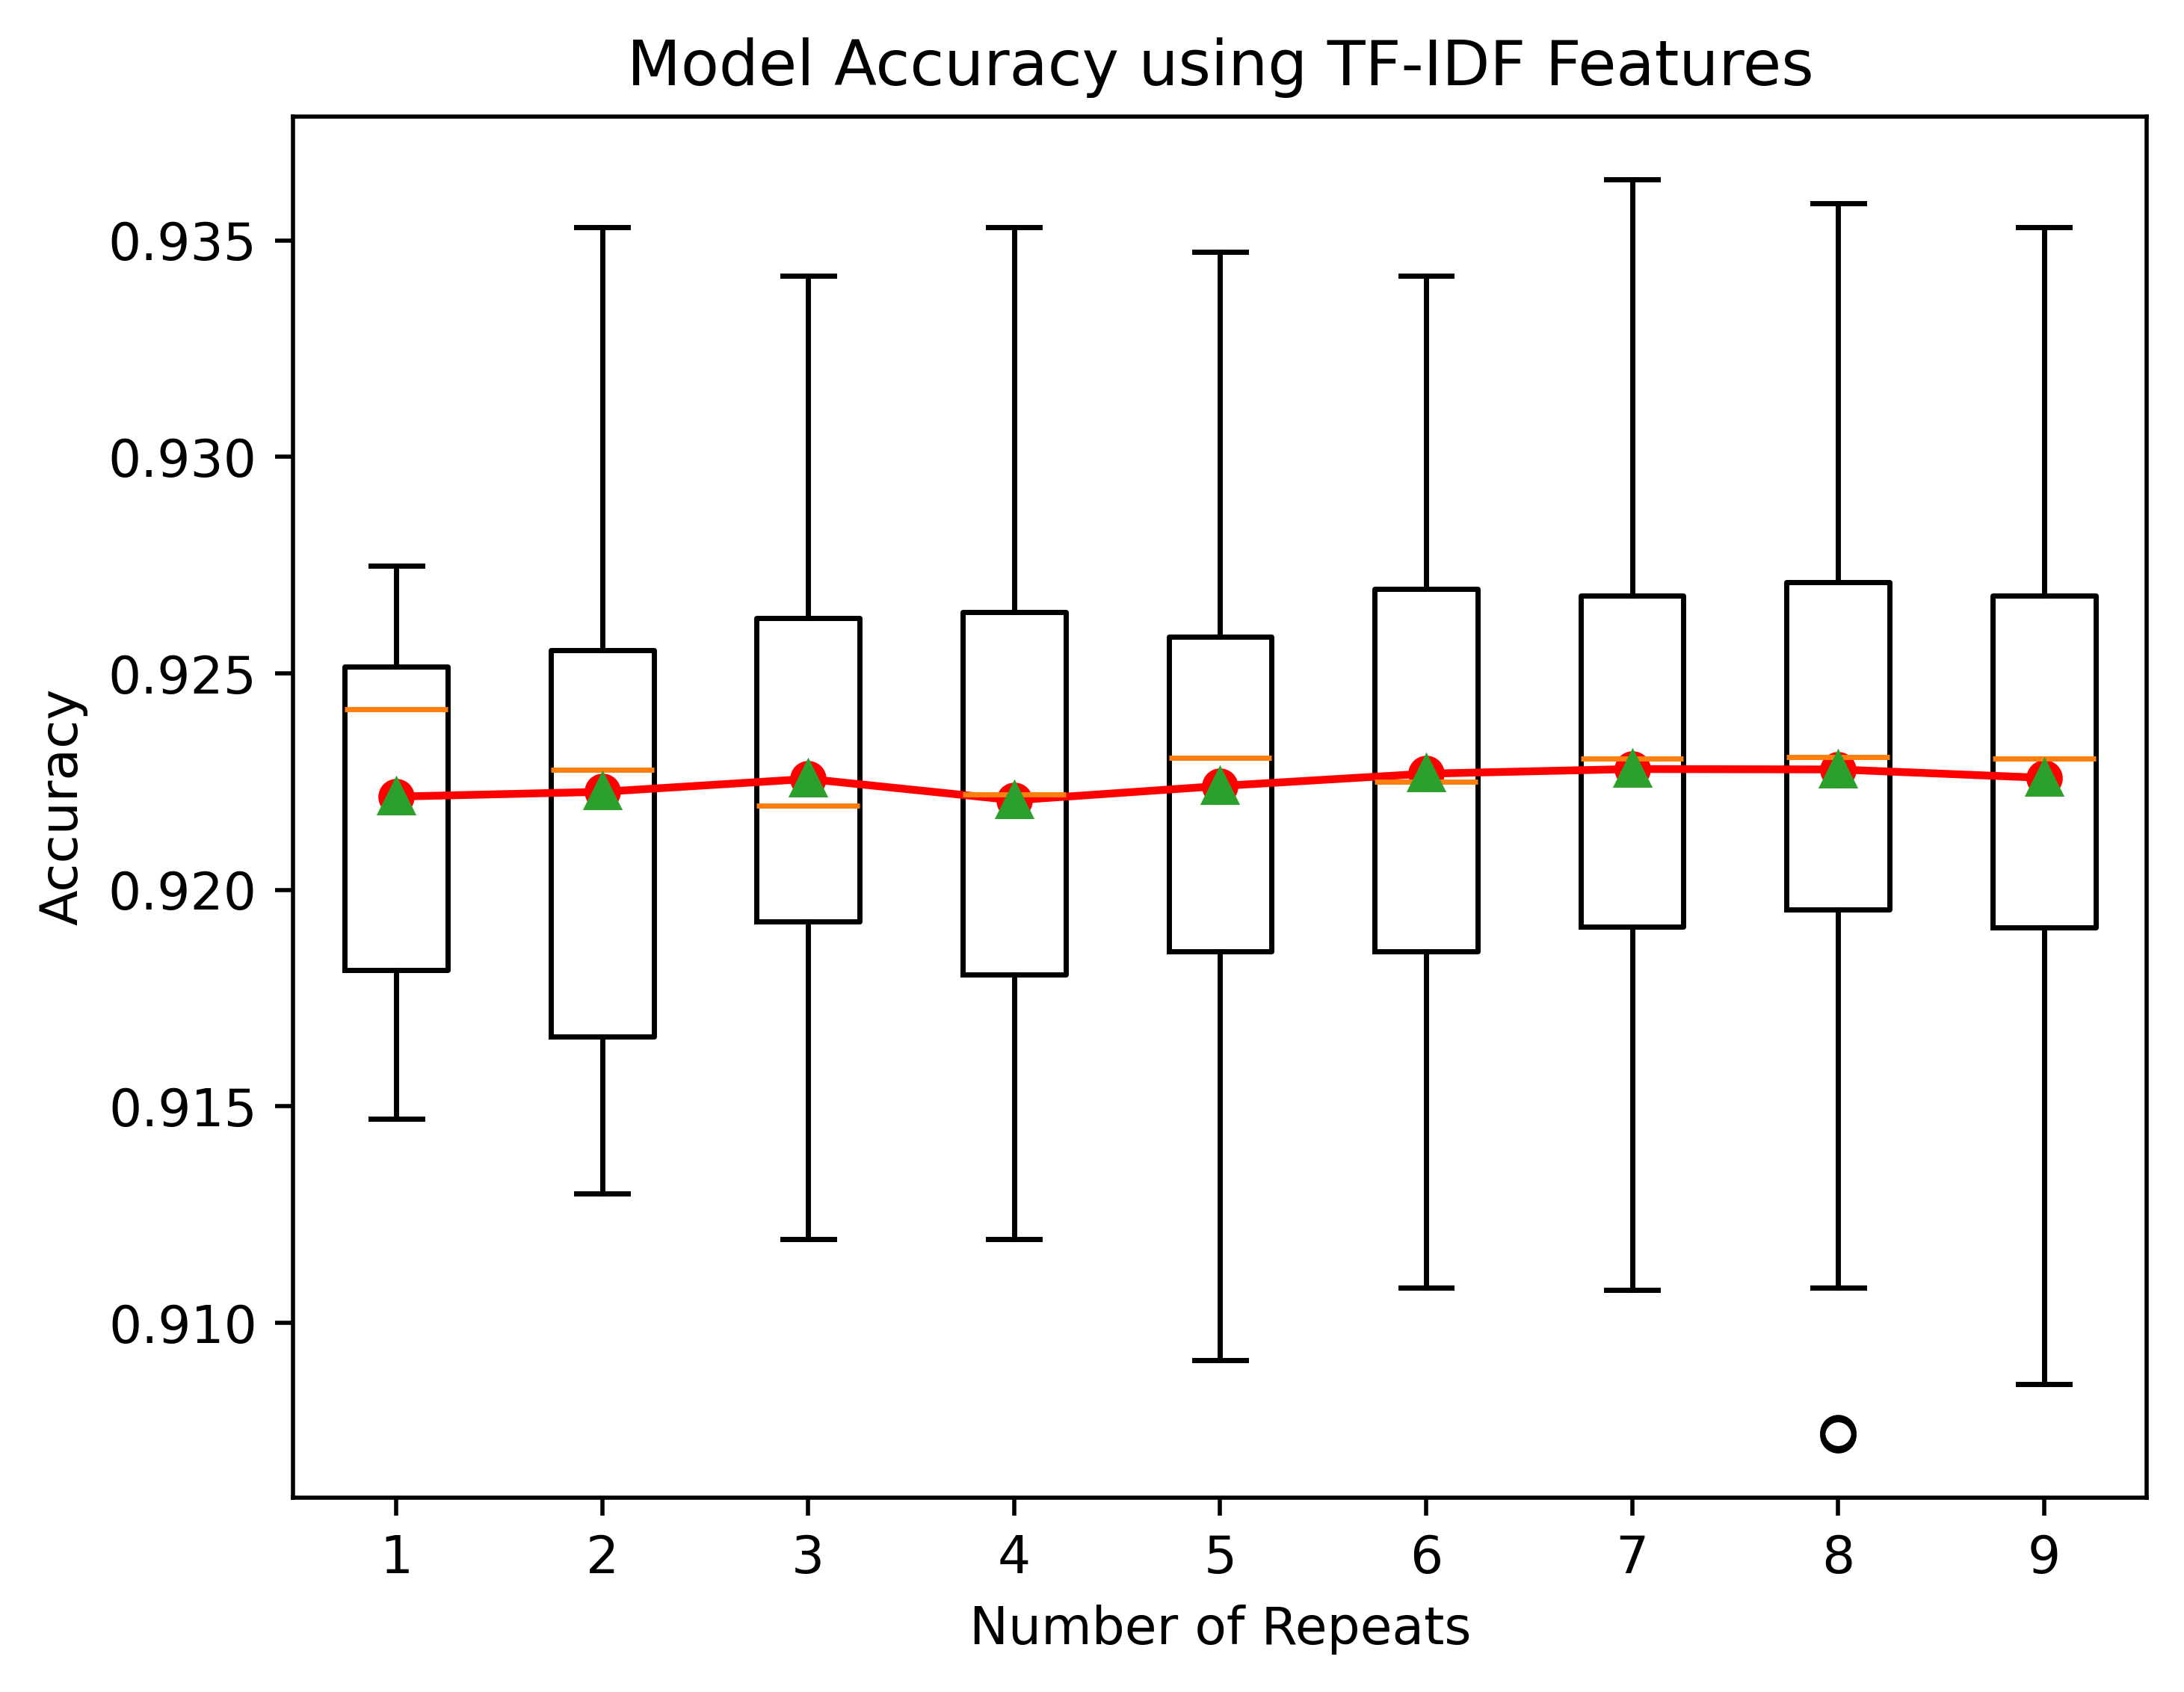

In [19]:
results = []  # List to store the results of each evaluation
mean_scores = []  # List to store mean accuracy for plotting

# Assume 'features_train_tfidf_combined' and 'target_train' are defined elsewhere
features = features_train_tfidf_combined
target = target_train

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(features, target, r)
    # Summarize and print the mean accuracy and SEM
    mean_accuracy = np.mean(scores)
    accuracy_sem = sem(scores)
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {accuracy_sem:.3f}')
    # Store the results
    results.append(scores)
    mean_scores.append(mean_accuracy)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.plot(range(1, 10), mean_scores, 'o-', color='red')  # Mean accuracy trend line
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_voting_tfidf"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/145/{model}.csv', index=False)

### BoW

Cross-Validation Repeats: 1, Mean Accuracy: 0.9225, SEM: 0.001
Cross-Validation Repeats: 2, Mean Accuracy: 0.9235, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9233, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9236, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9237, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9236, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9236, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9236, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9236, SEM: 0.001


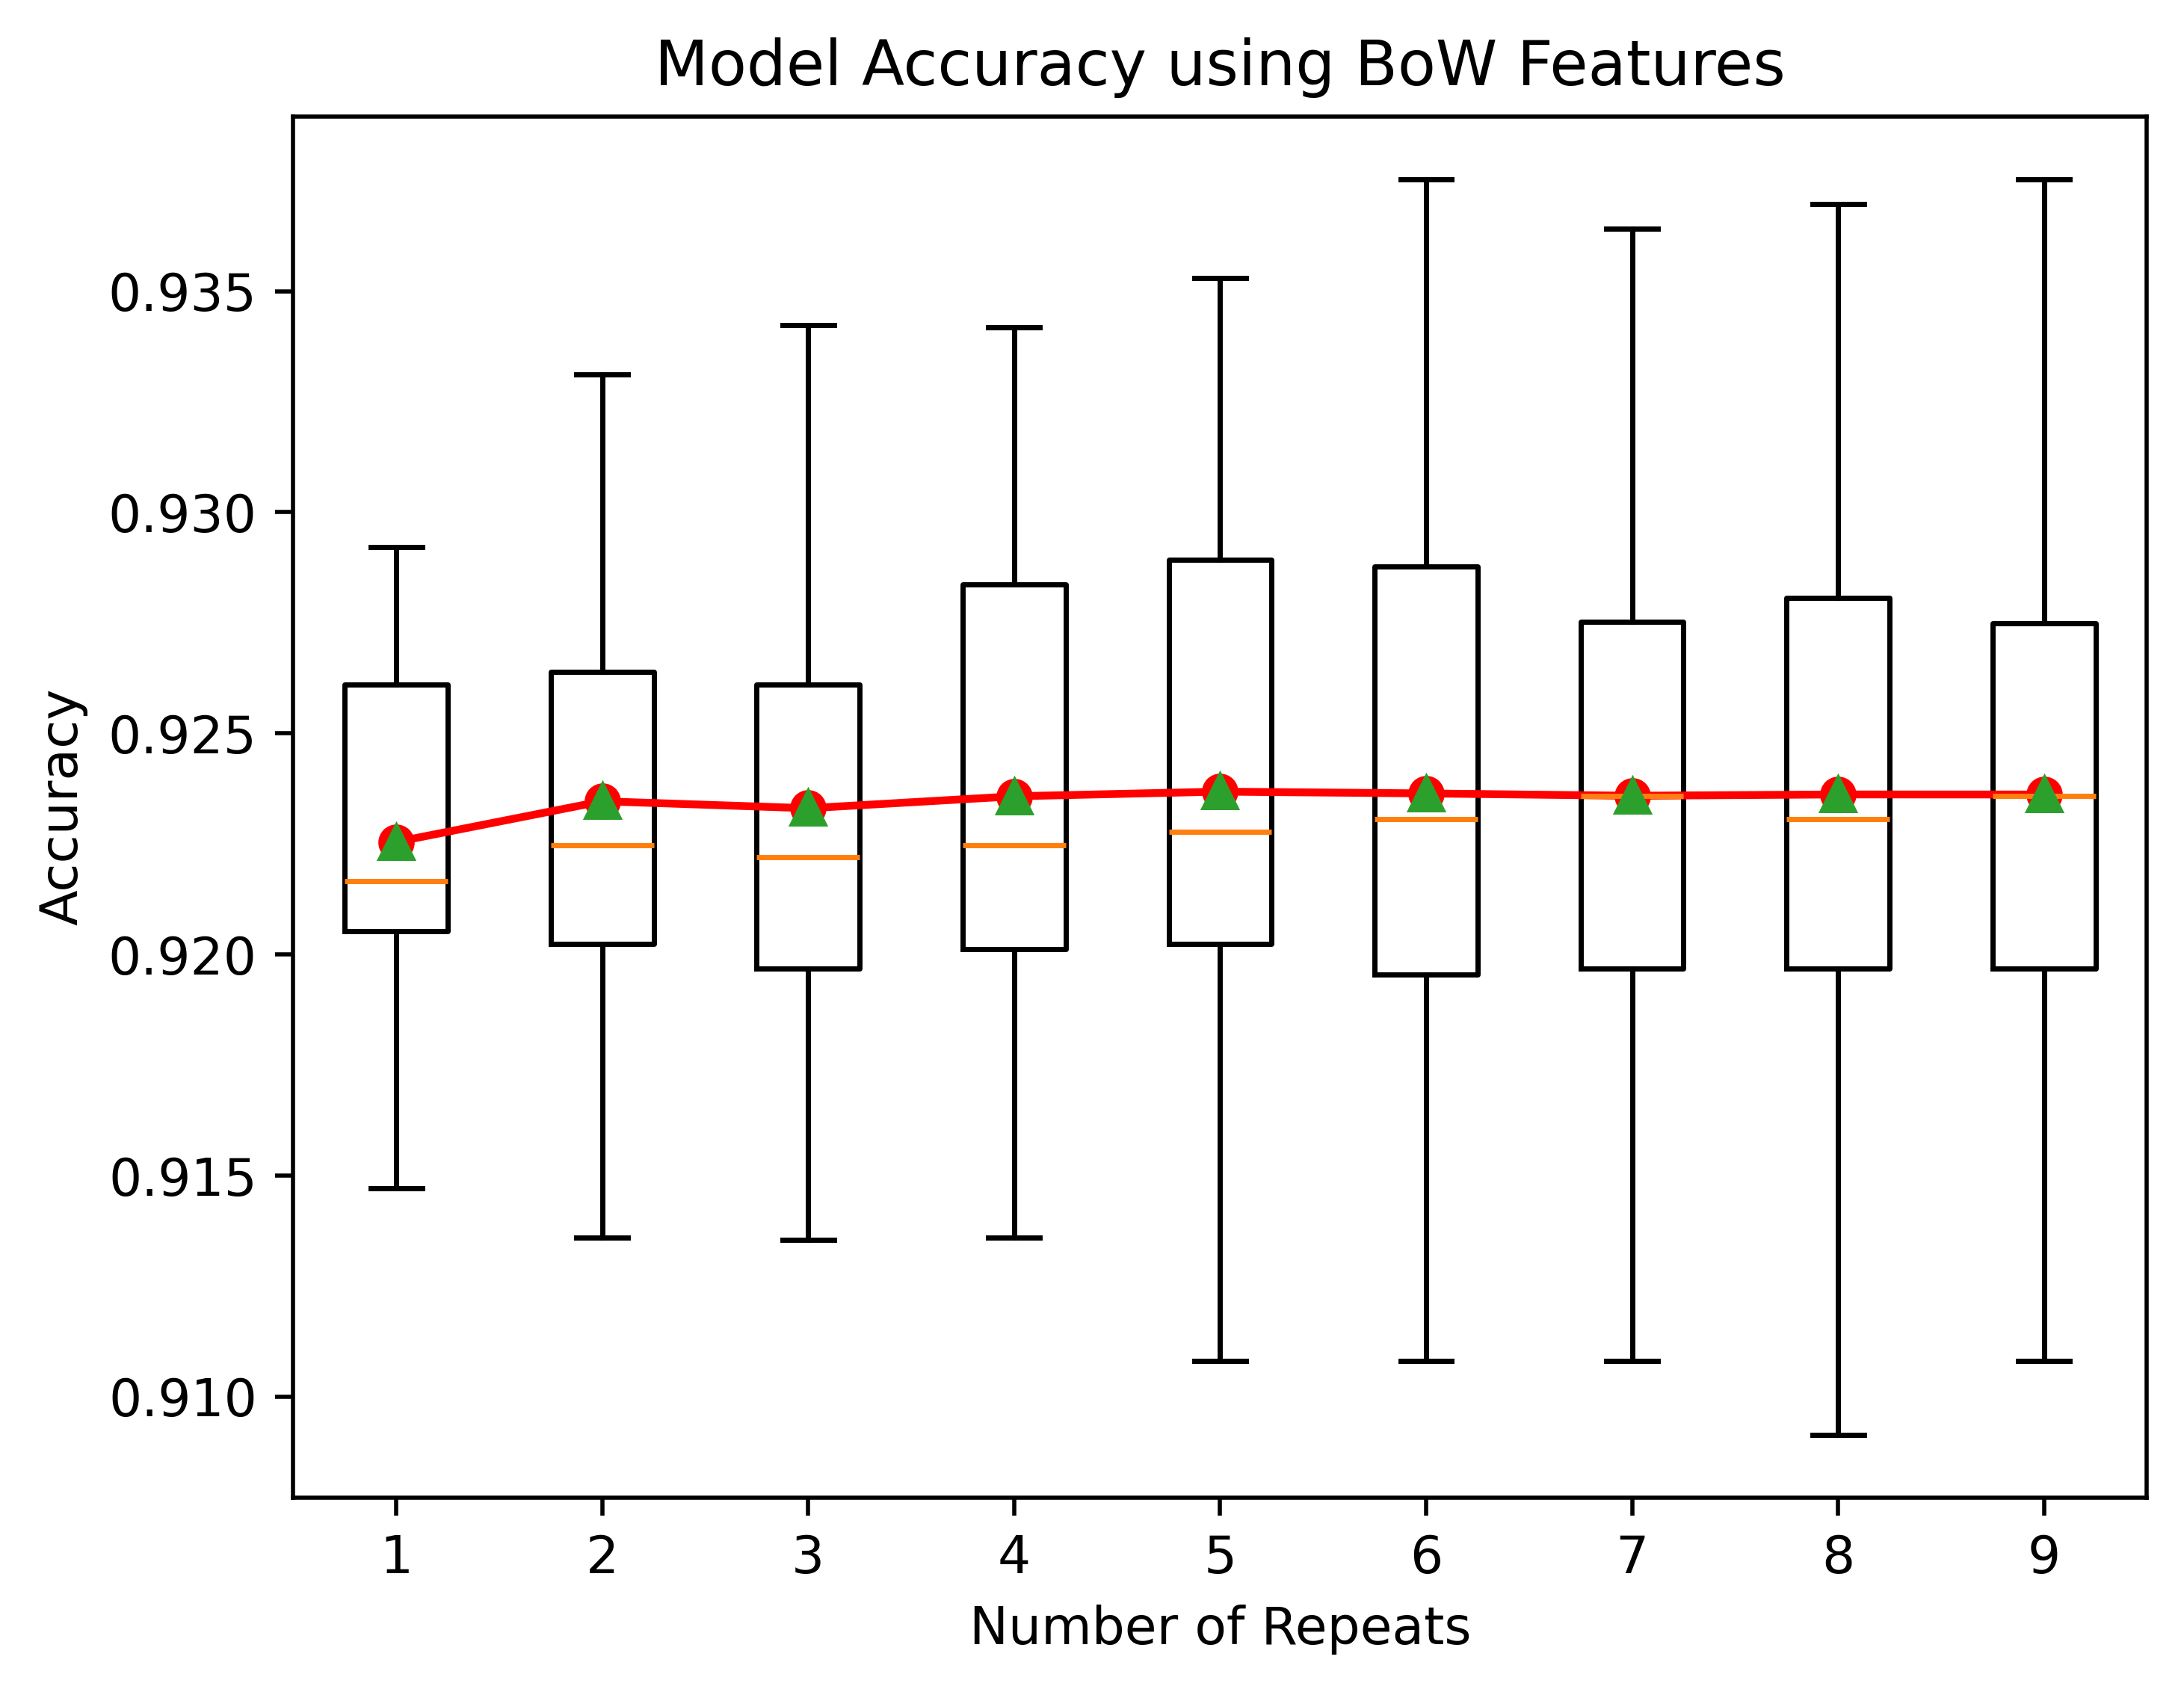

In [20]:
results = []  # List to store the results of each evaluation
mean_scores = []  # List to store mean accuracy for plotting

# Assume 'features_train_tfidf_combined' and 'target_train' are defined elsewhere
features = features_train_bow_combined
target = target_train

# Evaluate the model using BoW combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(features, target, r)
    # Summarize and print the mean accuracy and SEM
    mean_accuracy = np.mean(scores)
    accuracy_sem = sem(scores)
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {mean_accuracy:.4f}, SEM: {accuracy_sem:.3f}')
    # Store the results
    results.append(scores)
    mean_scores.append(mean_accuracy)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.plot(range(1, 10), mean_scores, 'o-', color='red')  # Mean accuracy trend line
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "rf_voting_bow"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/145/{model}.csv', index=False)